<a href="https://colab.research.google.com/github/Cal723/CSE-337-Labs/blob/main/ChessEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chess
!pip install torch torchvision torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import chess
import chess.engine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available, using CPU.")


print("Number of GPUs:", torch.cuda.device_count())
print("MPS Available:", torch.backends.mps.is_available())

try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    print("TPU Available:", xm.xla_device())
except ImportError:
    print("TPU not available.")

GPU: NVIDIA L4
Number of GPUs: 1
MPS Available: False
TPU not available.


In [ ]:

def board_to_tensor(board, turn):

    tensor = torch.zeros(13, 8, 8)

    for square in range(64):
        piece = board.piece_at(square)
        if piece:
            piece_type = piece.piece_type - 1
            color_offset = 0 if piece.color == chess.WHITE else 6
            tensor[color_offset + piece_type, square // 8, square % 8] = 1


    tensor[12, :, :] = turn


    return tensor


In [ ]:
import chess
import torch

def get_legal_tensor(board):
    legal_move_list = list(board.legal_moves)
    move_tensor = torch.zeros(4352)
    for move in legal_move_list:
        from_square = move.from_square
        to_square = move.to_square
        piece = board.piece_at(from_square)
        idx = encode_move(move)
        move_tensor[idx] = 1
    return move_tensor

def get_row_col(square):
    row = square // 8
    col = square % 8
    return row, col

PROMOTION_PIECES = ['q', 'r', 'b', 'n']

def encode_move(move):
    from_square = move.from_square
    to_square = move.to_square

    if move.promotion is None:
        return from_square * 64 + to_square
    else:
        promotion_index = PROMOTION_PIECES.index(chess.piece_symbol(move.promotion))
        return 4096 + from_square * 4 + promotion_index

def decode_move(index):
    if index < 4096:
        from_square = index // 64
        to_square = index % 64
        return chess.Move(from_square, to_square)
    else:
        promotion_index = index - 4096
        from_square = promotion_index // 4
        promo_piece = PROMOTION_PIECES[promotion_index % 4]
        rank_offset = 8 if chess.square_rank(from_square) == 6 else -8
        to_square = from_square + rank_offset
        return chess.Move(from_square, to_square, promotion=chess.Piece.from_symbol(promo_piece).piece_type)


board = chess.Board()
legal_tensor = get_legal_tensor(board)
print(legal_tensor)

print(f"Shape of the tensor: {legal_tensor.shape}")
print(f"Type of the tensor: {legal_tensor.dtype}")

tensor([0., 0., 0.,  ..., 0., 0., 0.])
Shape of the tensor: torch.Size([4352])
Type of the tensor: torch.float32


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, num_actions=4352):
        super(DQN, self).__init__()


        self.conv1 = nn.Conv2d(13, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)


        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_actions)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
import random
from collections import deque


class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

replay_buffer = ReplayBuffer(10000)


def select_action(board, state, q_network, epsilon):
    legal_moves = list(board.legal_moves)

    if random.random() < epsilon:
        print("Exploration Move")
        move = random.choice(legal_moves)
        return encode_move(move)

    print("Predicted Move")
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

    q_values = q_network(state_tensor).squeeze(0)
    legal_move_mask = get_legal_tensor(board).to(device)

    q_values[legal_move_mask == 0] = -float('inf')

    best_move_index = torch.argmax(q_values).item()
    return best_move_index



def train(q_network, target_network, replay_buffer, batch_size, gamma, optimizer, criterion):
    if replay_buffer.size() < batch_size:
        return

    batch = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.stack(states).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.stack(next_states).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).to(device)

    q_values = q_network(states).gather(1, actions).squeeze(1)
    with torch.no_grad():
        next_q_values = target_network(next_states).max(1)[0]
        expected_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = criterion(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(q_network.parameters(), max_norm=1.0)

    optimizer.step()


In [ ]:
!pip install sympy

In [ ]:
!apt-get update
!apt-get install stockfish

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,196 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,507 kB]
Hit:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa

In [ ]:
!find / -name "stockfish" 2>/dev/null


^C


In [ ]:
import math
import chess.engine
import matplotlib.pyplot as plt
import numpy as np

def get_capture_reward(board, move):
    piece_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9,
        chess.KING: 0
    }

    reward = 0.0
    captured_piece = board.piece_at(move.to_square)
    if captured_piece:
        reward += piece_values[captured_piece.piece_type]

    board.push(move)
    if board.is_check():
        reward += 0.85
    board.pop()

    return reward


In [ ]:
def moving_average(values, window):
  return np.convolve(values, np.ones(window)/window, mode='valid')

Greedy Agent



In [ ]:
def greedy_move(board):
    legal_moves = list(board.legal_moves)
    if not legal_moves:
        return None

    best_move = None
    best_reward = -float('inf')
    for move in legal_moves:
        reward = get_capture_reward(board, move)
        if reward > best_reward:
            best_reward = reward
            best_move = move

    if best_move is None:
        best_move = random.choice(legal_moves)

    return best_move

def run_greedy_baseline(num_games):
    engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
    episode_rewards = []

    for episode in range(num_games):
        board = chess.Board()
        total_reward = 0
        model_is_white = 1
        done = False

        while not done:
            # Greedy model move
            move = greedy_move(board)
            if move is None:
                break
            reward = get_capture_reward(board, move)
            total_reward += reward
            board.push(move)

            if not board.is_game_over():
                result = engine.play(board, chess.engine.Limit(time=0.1))
                stockfish_move = result.move
                reward = -get_capture_reward(board, stockfish_move)
                board.push(stockfish_move)
                total_reward += reward

            if board.is_game_over():
                result_str = board.result()
                if (result_str == "1-0" and model_is_white == 1) or (result_str == "0-1" and model_is_white == 0):
                    total_reward += 100
                elif result_str == "1/2-1/2" or  board.is_stalemate():
                    total_reward += 0
                else:
                    total_reward -= 100
                done = True

        episode_rewards.append(total_reward)
        model_is_white = 0 if model_is_white == 1 else 1

    engine.quit()
    return episode_rewards




In [ ]:

# Got gpt help for plotting
def plot_overlay(results, window=20):
    combos = list(results.keys())

    fig, axes = plt.subplots(3, 1, figsize=(12, 14))
    ax_rewards, ax_eps, ax_moves = axes

    for i, combo in enumerate(combos):
        seeds = results[combo].keys()

        reward_runs = []
        eps_runs = []
        move_runs = []

        for seed in seeds:
            data = results[combo][seed]

            rewards = np.array(data["episode_rewards"])
            eps = np.array(data["episode_epsilons"])
            moves = np.array(data["move_pairs"])

            reward_runs.append(rewards)
            eps_runs.append(eps)
            move_runs.append(moves)

            ma_rewards = moving_average(rewards, window)
            ax_rewards.plot(range(window-1, len(rewards)), ma_rewards,
                            alpha=0.25, color=f"C{i}")

            ma_moves = moving_average(moves, window)
            ax_moves.plot(range(window-1, len(moves)), ma_moves,
                          alpha=0.25, color=f"C{i}")

        reward_arr = np.vstack(reward_runs)
        eps_arr = np.vstack(eps_runs)
        moves_arr = np.vstack(move_runs)

        mean_rewards = moving_average(reward_arr.mean(axis=0), window)
        std_rewards = moving_average(reward_arr.std(axis=0), window)

        mean_moves = moving_average(moves_arr.mean(axis=0), window)
        std_moves = moving_average(moves_arr.std(axis=0), window)


        ax_rewards.plot(range(window-1, len(mean_rewards) + window-1),
                        mean_rewards, color=f"C{i}", linewidth=2,
                        label=f"{combo} (mean)")


        ax_rewards.fill_between(
            range(window-1, len(mean_rewards) + window-1),
            mean_rewards - std_rewards,
            mean_rewards + std_rewards,
            color=f"C{i}", alpha=0.15
        )

        ax_eps.plot(eps_arr.mean(axis=0), color=f"C{i}", linewidth=2,
                    label=f"{combo} (mean)")

        ax_moves.plot(range(window-1, len(mean_moves) + window-1),
                      mean_moves, color=f"C{i}", linewidth=2,
                      label=f"{combo} (mean)")

        ax_moves.fill_between(
            range(window-1, len(mean_moves) + window-1),
            mean_moves - std_moves,
            mean_moves + std_moves,
            color=f"C{i}", alpha=0.15
        )

    ax_rewards.set_title("Episode Rewards (Mean ± Std, Moving Average)")
    ax_rewards.set_xlabel("Episode")
    ax_rewards.set_ylabel("Reward")
    ax_rewards.legend()

    ax_eps.set_title("Episode Epsilon (Mean Across Seeds)")
    ax_eps.set_xlabel("Episode")
    ax_eps.set_ylabel("Epsilon")
    ax_eps.legend()

    ax_moves.set_title("Moves per Episode (Mean ± Std, Moving Average)")
    ax_moves.set_xlabel("Episode")
    ax_moves.set_ylabel("Moves")
    ax_moves.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def run_dqn_against_greedy(num_games, gamma, epsilon_start, epsilon_end, epsilon_decay,
                           batch_size, lr, seed, capacity=50000, best_model_reward=float('-inf')):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    replay_buffer = ReplayBuffer(capacity)
    TARGET_UPDATE_EVERY = 100
    q_network = DQN().to(device)
    target_network = DQN().to(device)
    target_network.load_state_dict(q_network.state_dict())
    optimizer = optim.Adam(q_network.parameters(), lr)
    criterion = nn.MSELoss()

    global_step = 0
    epsilon = epsilon_start

    episode_rewards = []
    episode_epsilons = []
    move_pairs_per_episode = []

    engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
    model_is_white = 1
    for episode in range(num_games):
        print(f"Episode {episode}")
        board = chess.Board()
        total_reward = 0.0
        done = False
        move_nums = 0
        turn = 1

        if model_is_white == 0:
            legal = list(board.legal_moves)
            if not legal:
                episode_rewards.append(0.0)
                episode_epsilons.append(epsilon)
                move_pairs_per_episode.append(0)
                continue

            greedy_move_selection = greedy_move(board)
            if greedy_move_selection is None or greedy_move_selection not in board.legal_moves:
                greedy_move_selection = random.choice(legal)

            board.push(greedy_move_selection)
            move_nums += 1
            turn = -1
            print(f"Greedy Algorithm plays: {greedy_move_selection}")
            print(board, "\n")


        while not done:
            global_step += 1
            move_nums += 1
            state = board_to_tensor(board,turn).to(device)
            epsilon = max(epsilon_end, epsilon*epsilon_decay)
            best_move_index = select_action(board, state, q_network, epsilon)
            decided_best = decode_move(best_move_index)
            legal = list(board.legal_moves)
            if decided_best not in legal:
                decided_best = random.choice(legal)

            reward = get_capture_reward(board, decided_best)
            board.push(decided_best)
            print(f"{'White' if turn==1 else 'Black'} (Model) move: {decided_best}")
            print(board, "\n")
            turn = -turn

            if not board.is_game_over():
                print("Greedy Algorithm's Move")
                greedy_move_selection = greedy_move(board)
                legal = list(board.legal_moves)
                if greedy_move_selection is None or greedy_move_selection not in legal:
                    greedy_move_selection = random.choice(legal)

                reward -= get_capture_reward(board, greedy_move_selection)
                print(f"Greedy Algorithm plays: {greedy_move_selection}")
                board.push(greedy_move_selection)
                print(board, "\n")
                turn = -turn
                move_nums += 1

            next_state = board_to_tensor(board, turn).to(device)
            if board.is_game_over():
                result_str = board.result()
                if (result_str == "1-0" and model_is_white == 1) or (result_str == "0-1" and model_is_white == 0):
                    reward = 100.0
                elif board.is_stalemate() or result_str == "1/2-1/2":
                    reward = 0.0
                else:
                    reward = -100.0
                done = True

            action = best_move_index
            replay_buffer.add(state, action, reward, next_state, done)

            total_reward += reward

            if replay_buffer.size() >= batch_size:
                print("Training on replay buffer\n")
                train(q_network, target_network, replay_buffer, batch_size, gamma, optimizer, criterion)
                print("Training complete\n")

            if global_step % TARGET_UPDATE_EVERY == 0:
                target_network.load_state_dict(q_network.state_dict())
                print("Target network updated!")

        if total_reward > best_model_reward:
            best_model_reward = total_reward
            model_filename = "dqn_v_greedy.pth"
            model_path = os.path.join(save_path, model_filename)
            torch.save(q_network.state_dict(), model_path)
            meta_path = model_path.replace(".pth", "_meta.json")
            with open(meta_path, "w") as f:
                json.dump({
                    "episode": episode,
                    "best_reward": best_model_reward,
                    "lr": lr,
                    "gamma": gamma
                }, f, indent=2)
            print(f"\nNew best model saved: {model_filename}\n")

        print(f"Episode {episode}, Total Reward: {total_reward}")
        model_is_white = 0 if model_is_white == 1 else 1
        move_pairs = move_nums // 2
        move_pairs_per_episode.append(move_pairs)
        episode_rewards.append(total_reward)
        episode_epsilons.append(epsilon)

    engine.quit()
    return episode_rewards, episode_epsilons, move_pairs_per_episode, best_model_reward


In [ ]:
def run_td_lambda_vs_greedy(num_games, agent,epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,seed=1, best_model_reward=float('-inf')):

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    epsilon = epsilon_start
    model_is_white = 1

    episode_rewards = []
    episode_epsilons = []
    move_pairs_per_episode = []

    for episode in range(num_games):
        print(f"\nEpisode {episode}")

        board = chess.Board()
        total_reward = 0
        done = False
        move_nums = 0
        turn = 1 if model_is_white else -1

        agent.reset_traces()

        if model_is_white == 0:
            gm = greedy_move(board)
            if gm is None or gm not in board.legal_moves:
                gm = random.choice(list(board.legal_moves))
            board.push(gm)
            print(f"Greedy (White) plays: {gm}\n{board}\n")
            turn = -1
            move_nums += 1

        while not done:
            move_nums += 1

            state = board_to_tensor(board, turn).to(device)

            legal_moves = list(board.legal_moves)
            if not legal_moves:
                done = True
                break

            if random.random() < epsilon:
                move = random.choice(legal_moves)

            else:
                best_value = -float('inf')
                best_move = None

                for m in legal_moves:
                    board.push(m)
                    val = agent.predict(board_to_tensor(board, -turn))
                    board.pop()
                    if val > best_value:
                        best_value = val
                        best_move = m

                move = best_move if best_move is not None else random.choice(legal_moves)

            reward = get_capture_reward(board, move)
            board.push(move)
            print(f"{'White' if turn==1 else 'Black'} (Model) move: {move}\n{board}\n")
            turn *= -1

            if not board.is_game_over():
                gm = greedy_move(board)
                legal = list(board.legal_moves)
                if gm is None or gm not in legal:
                    gm = random.choice(legal)

                reward -= get_capture_reward(board, gm)
                board.push(gm)
                print(f"{'White' if turn==1 else 'Black'} (Greedy) move: {gm}\n{board}\n")

                turn *= -1
                move_nums += 1


            next_state = board_to_tensor(board,turn).to(device)

            if board.is_game_over():
                result = board.result()
                if (result == "1-0" and  model_is_white == 1) or (result == "0-1" and model_is_white == 0):
                    reward = 100
                elif board.is_stalemate() or result == "1/2-1/2":
                    reward = 0
                else:
                    reward = -100

                done = True

            total_reward += reward

            agent.update(state, next_state, reward, done)

            epsilon = max(epsilon_end, epsilon * epsilon_decay)

        episode_rewards.append(total_reward)
        episode_epsilons.append(epsilon)
        move_pairs_per_episode.append(move_nums // 2)


        if total_reward > best_model_reward:
            best_model_reward = total_reward
            model_path = os.path.join(save_path, "td_lambda_greedy.pth")
            torch.save(agent.value_network.state_dict(), model_path)
            meta_path = model_path.replace(".pth", "_meta.json")
            with open(meta_path, "w") as f:
                json.dump({
                    "episode": episode,
                    "best_reward": best_model_reward,
                    "gamma": agent.gamma,
                    "lambda_val": agent.lambda_val
                }, f, indent=2)
            print(f"Saved new best model: {model_path}")

        model_is_white = 0 if model_is_white == 1 else 1

    return episode_rewards, episode_epsilons, move_pairs_per_episode, best_model_reward


# **DQN Training against Stockfish**


In [ ]:
import json, os

save_path = "best_models"
os.makedirs(save_path, exist_ok=True)

def run_dqn(num_games, gamma,epsilon_start, epsilon_end, epsilon_decay, batch_size, lr, seed,capacity=50000,best_model_reward=float('-inf')):
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)
  replay_buffer = ReplayBuffer(capacity)
  move_nums = 1
  target_update_frequency = 100
  engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
  total_captures = 0
  total_checkmates = 0
  total_moves_to_checkmate = 0
  captures_per_episode = []
  avg_moves_to_checkmate_over_time = []
  move_pairs_per_episode = []
  q_network = DQN().to(device)
  target_network = DQN().to(device)
  target_network.load_state_dict(q_network.state_dict())
  optimizer = optim.Adam(q_network.parameters(), lr)
  criterion = nn.MSELoss()
  global_step = 0
  epsilon = epsilon_start
  episode_rewards = []
  episode_epsilons = []
  avg_reward_per_epoch = []
  model_is_white = 1


  for episode in range(num_games):
      print(f"Episode {episode}")
      board = chess.Board()
      total_reward = 0
      done = False
      move_nums = 0
      turn = 1 if model_is_white else -1

      if model_is_white == 0:
          result = engine.play(board, chess.engine.Limit(time=0.1))
          move_nums += 1
          turn = -1
          board.push(result.move)
          print(f"Stockfish plays: {result.move}")
          print(f"{board}\n")
          state = board_to_tensor(board, turn).to(device)


      while not done:
          global_step += 1
          move_nums += 1
          print(f"Move {move_nums}")
          state = board_to_tensor(board, turn).to(device)
          epsilon = max(epsilon_end, epsilon * epsilon_decay)
          best_move_index = select_action(board, state, q_network, epsilon)
          move = decode_move(best_move_index)
          reward = get_capture_reward(board, move)
          board.push(move)

          if turn == -1:
            print(f"Black(Model) move: {move}")
          else:
            print(f"White(Model) move: {move}")

          print(f"{board}\n")
          turn = turn * -1

          if not board.is_game_over():
            print("Stockfish's Move")
            result = engine.play(board, chess.engine.Limit(time=0.1))
            Stockfish_Move = result.move

            reward -= get_capture_reward(board, Stockfish_Move)

            print(f"Stockfish) plays: {Stockfish_Move}")
            board.push(Stockfish_Move)

            if turn == -1:
                print(f"Black move: {Stockfish_Move}")
            else:
                print(f"White move: {Stockfish_Move}")

            print(f"{board}\n")
            turn = turn * -1
            move_nums += 1

          next_state = board_to_tensor(board, turn).to(device)

          if board.is_game_over():

              if board.result() == "1-0" and model_is_white == 1 or board.result() == "0-1" and model_is_white == 0:
                  reward = 100

              elif board.is_stalemate() or board.result() == "1/2-1/2":
                  reward = 0
              else:
                  reward = -100

              done = True


          action = best_move_index
          replay_buffer.add(state, action, reward, next_state, done)

          total_reward += reward

          if replay_buffer.size() >= batch_size:
              print("Training on replay buffer\n")
              train(q_network, target_network, replay_buffer, batch_size, gamma, optimizer, criterion)
              print("Training complete\n")

          if global_step % target_update_frequency == 0:
              target_network.load_state_dict(q_network.state_dict())
              print("Target network updated!")

      if total_reward > best_model_reward:
          best_model_reward = total_reward
          model_filename = f"best_dqn_reward.pth"
          model_path = os.path.join(save_path, model_filename)
          torch.save(q_network.state_dict(), model_path)
          meta_path = model_path.replace(".pth", "_meta.json")
          with open(meta_path, "w") as f:
              json.dump({"episode": episode,"best_reward": best_model_reward, "lr": lr,}, f, indent=2)

          print(f"\nNew best model saved: {model_filename}\n")

      print(f"Episode {episode}, Total Reward: {total_reward}")
      model_is_white = 0 if model_is_white == 1 else 1
      move_pairs = move_nums // 2
      move_pairs_per_episode.append(move_pairs)
      episode_rewards.append(total_reward)
      episode_epsilons.append(epsilon)




  return episode_rewards, episode_epsilons, move_pairs_per_episode, best_model_reward

In [ ]:

save_path = "best_td_lambda_models"
os.makedirs(save_path, exist_ok=True)


import torch.nn.functional as F

class TDLambdaValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(13, 32, 3, padding=1)
        self.ln1 = nn.LayerNorm([32, 8, 8])

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.ln2 = nn.LayerNorm([64, 8, 8])

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.ln3 = nn.LayerNorm([128, 8, 8])

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.leaky_relu(self.ln1(self.conv1(x)))
        x = F.leaky_relu(self.ln2(self.conv2(x)))
        x = F.leaky_relu(self.ln3(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)

        return x



class TDLambdaAgent:
    def __init__(self, value_network, lr=1e-4, gamma=0.99, lambda_val=0.8):
        self.value_network = value_network.to(device)
        self.optimizer = optim.Adam(self.value_network.parameters(), lr=lr)
        self.gamma = gamma
        self.lambda_val = lambda_val
        self.device = device

        self.traces = {
            name: torch.zeros_like(param, device=device)
            for name, param in self.value_network.named_parameters()
        }


        self.max_trace_norm = 1.0
        self.max_td_error = 10.0

    def reset_traces(self):
        for k in self.traces:
            self.traces[k].zero_()

    def predict(self, state_tensor):
        with torch.no_grad():
            state_tensor = state_tensor.to(self.device)
            return self.value_network(state_tensor.unsqueeze(0)).squeeze().item()

    def update(self, state, next_state, reward, done):
      state = state.to(self.device).float()
      next_state = next_state.to(self.device).float()
      reward = torch.tensor(reward, dtype=torch.float32, device=self.device)


      state_value = self.value_network(state.unsqueeze(0)).squeeze()
      with torch.no_grad():
          next_value = torch.tensor(0.0, device=self.device) if done else \
                      self.value_network(next_state.unsqueeze(0)).squeeze()


      td_error = reward + self.gamma * next_value - state_value


      self.optimizer.zero_grad()
      state_value.backward()

      for name, param in self.value_network.named_parameters():
          if param.grad is None:
              continue

          self.traces[name] = self.gamma * self.lambda_val * self.traces[name] + param.grad.detach()

          param.grad.data.copy_((-td_error * self.traces[name]).data)

      self.optimizer.step()

      if done:
          self.reset_traces()

    def select_move(self, board, turn):
        legal_moves = list(board.legal_moves)

        if not legal_moves:
            return None

        best_value = -float('inf')
        best_move = None

        for move in legal_moves:
            board.push(move)
            value = self.predict(board_to_tensor(board, -turn))
            board.pop()

            if value > best_value:
                best_value = value
                best_move = move

        return best_move if best_move else random.choice(legal_moves)






def run_td_lambda(num_games, agent, epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995, seed=42, best_model_reward=float('-inf')):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")

    epsilon = epsilon_start
    model_is_white = 1
    episode_rewards = []
    episode_epsilons = []
    move_pairs_per_episode = []

    for episode in range(num_games):
        board = chess.Board()
        total_reward = 0
        done = False
        move_nums = 0
        turn = 1 if model_is_white else -1

        agent.reset_traces()


        if model_is_white == 0:
            result = engine.play(board, chess.engine.Limit(time=0.1))
            board.push(result.move)
            turn = -1
            move_nums += 1

        while not done:
            move_nums += 1
            state = board_to_tensor(board, turn)
            legal_moves = list(board.legal_moves)
            if not legal_moves:
                done = True
                break
            if random.random() < epsilon:
                move = random.choice(legal_moves)
            else:
                best_value = -float('inf')
                best_move = None
                for m in legal_moves:
                    board.push(m)
                    val = agent.predict(board_to_tensor(board, -turn))
                    board.pop()
                    if val > best_value:
                        best_value = val
                        best_move = m
                move = best_move if best_move is not None else random.choice(legal_moves)


            reward = get_capture_reward(board, move)
            board.push(move)
            print(f"{'White' if turn==1 else 'Black'} (Model) move: {move}")
            print(board, "\n")
            turn *= -1

            # Stockfish move
            if not board.is_game_over():
                result = engine.play(board, chess.engine.Limit(time=0.1))
                stockfish_move = result.move
                reward -= get_capture_reward(board, stockfish_move)
                board.push(stockfish_move)
                print(f"{'White' if turn==1 else 'Black'} (Stockfish) move: {stockfish_move}")
                print(board, "\n")
                turn *= -1
                move_nums += 1

            next_state = board_to_tensor(board, turn)
            if board.is_game_over():
                result_str = board.result()
                if result_str == "1-0" and model_is_white==1 or result_str=="0-1" and model_is_white==0:
                    reward = 100
                elif board.is_stalemate() or result_str=="1/2-1/2":
                    reward = 0
                else:
                    reward = -100
                done = True

            total_reward += reward
            agent.update(state, next_state, reward, done)

            epsilon = max(epsilon_end, epsilon * epsilon_decay)

        episode_rewards.append(total_reward)
        episode_epsilons.append(epsilon)
        move_pairs_per_episode.append(move_nums//2)


        if total_reward > best_model_reward:
            best_model_reward = total_reward
            model_path = os.path.join(save_path, "best_td_lambda.pth")
            torch.save(agent.value_network.state_dict(), model_path)
            meta_path = model_path.replace(".pth", "_meta.json")
            with open(meta_path, "w") as f:
                json.dump({"episode":episode,"best_reward":best_model_reward,"gamma":agent.gamma,"lambda_val":agent.lambda_val}, f, indent=2)

        model_is_white = 0 if model_is_white==1 else 1

    engine.quit()
    return episode_rewards, episode_epsilons, move_pairs_per_episode, best_model_reward


In [ ]:
def run_td_lambda_vs_greedy(num_games, agent,
                            epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
                            seed=42, best_model_reward=float('-inf')):

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    epsilon = epsilon_start
    model_is_white = 1
    episode_rewards = []
    episode_epsilons = []
    move_pairs_per_episode = []

    for episode in range(num_games):
        print(f"\nGame {episode} ")

        board = chess.Board()
        total_reward = 0
        done = False
        move_nums = 0
        turn = 1 if model_is_white else -1

        agent.reset_traces()


        if model_is_white == 0:
            g_move = greedy_move(board)
            if g_move is None or g_move not in board.legal_moves:
                g_move = random.choice(list(board.legal_moves))
            board.push(g_move)
            print(f"Greedy (White) plays: {g_move}\n{board}\n")
            turn = -1
            move_nums += 1

        while not done:
            move_nums += 1
            state = board_to_tensor(board, turn).to(device)
            legal_moves = list(board.legal_moves)
            if not legal_moves:
                done = True
                break

            if random.random() < epsilon:
                move = random.choice(legal_moves)
            else:
                best_value = -float('inf')
                best_move = None

                for m in legal_moves:
                    board.push(m)
                    val = agent.predict(board_to_tensor(board, -turn))
                    board.pop()
                    if val > best_value:
                        best_value = val
                        best_move = m

                move = best_move if best_move is not None else random.choice(legal_moves)

            reward = get_capture_reward(board, move)
            board.push(move)
            print(f"{'White' if turn==1 else 'Black'} (Model) move: {move}\n{board}\n")
            turn *= -1


            if not board.is_game_over():
                g_move = greedy_move(board)
                legal = list(board.legal_moves)
                if g_move is None or g_move not in legal:
                    g_move = random.choice(legal)

                reward -= get_capture_reward(board, g_move)
                board.push(g_move)
                print(f"{'White' if turn==1 else 'Black'} (Greedy) move: {g_move}\n{board}\n")

                turn *= -1
                move_nums += 1


            next_state = board_to_tensor(board, turn).to(device)


            if board.is_game_over():
                result = board.result()
                if (result == "1-0" and model_is_white == 1) or (result == "0-1" and model_is_white == 0):
                    reward = 100
                elif board.is_stalemate() or result == "1/2-1/2":
                    reward = 0
                else:
                    reward = -100

                done = True

            total_reward += reward
            agent.update(state, next_state, reward, done)

            epsilon = max(epsilon_end, epsilon * epsilon_decay)

        episode_rewards.append(total_reward)
        episode_epsilons.append(epsilon)
        move_pairs_per_episode.append(move_nums // 2)


        if total_reward > best_model_reward:
            best_model_reward = total_reward
            model_path = os.path.join(save_path, "best_td_lambda_greedy.pth")
            torch.save(agent.value_network.state_dict(), model_path)
            meta_path = model_path.replace(".pth", "_meta.json")
            with open(meta_path, "w") as f:
                json.dump({
                    "episode": episode,
                    "best_reward": best_model_reward,
                    "gamma": agent.gamma,
                    "lambda_val": agent.lambda_val
                }, f, indent=2)
            print(f"Saved new best model: {model_path}")

        model_is_white = 0 if model_is_white == 1 else 1

    return episode_rewards, episode_epsilons, move_pairs_per_episode, best_model_reward


In [ ]:
learning_rates = [1e-4, 5e-4, 1e-3]
gammas = [0.9, 0.99]

dqn_search_results = {}
best_model_reward = float('-inf')
best_parameters = None

for lr in learning_rates:
    for gamma in gammas:
        print(f"\Parameters lr={lr}, gamma={gamma}")

        episode_rewards, episodess, moves, avg_reward = run_dqn_against_greedy(
            num_games=200,
            gamma=gamma,
            epsilon_start=1.0,
            epsilon_end=0.1,
            epsilon_decay=0.995,
            batch_size=32,
            lr=lr,
            seed=1,
            best_model_reward=float('-inf')
        )

        dqn_search_results[(lr, gamma)] = avg_reward

        if avg_reward > best_model_reward:
            best_model_reward = avg_reward
            best_parameters = (lr, gamma)

print("Best hyperparameter are:", best_parameters)


<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:10: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipython-input-1966906062.py:10: SyntaxWarning: invalid escape sequence '\P'
  print(f"\Parameters lr={lr}, gamma={gamma}")


\Parameters lr=0.0001, gamma=0.9
Episode 0
Exploration Move
White (Model) move: b1c3
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . N . . . . .
P P P P P P P P
R . B Q K B N R 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h6
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . .
. . N . . . . .
P P P P P P P P
R . B Q K B N R 

Exploration Move
White (Model) move: h2h4
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . P
. . N . . . . .
P P P P P P P .
R . B Q K B N R 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . P
. . N . . . . .
P P P P P P P .
R . B Q K B N R 

Exploration Move
White (Model) move: b2b3
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . P
. P N . . . . .
P . P P P P P .
R . B Q K B N R 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b q k b . r
p p p 

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
P . . . . P Q P
. . . . K R . .
. P P P R . . .
. . . N . . . .
. . . . . . . . 

Training on replay buffer

Training complete

Exploration Move
White (Model) move: g5e7
r n b . k b . r
p p . p Q p p p
. . . . . . . .
P . . . . P . P
. . . . K R . .
. P P P R . . .
. . . N . . . .
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: e8e7
r n b . . b . r
p p . p k p p p
. . . . . . . .
P . . . . P . P
. . . . K R . .
. P P P R . . .
. . . N . . . .
. . . . . . . . 

Training on replay buffer

Training complete

Exploration Move
White (Model) move: e3g3
r n b . . b . r
p p . p k p p p
. . . . . . . .
P . . . . P . P
. . . . K R . .
. P P P . . R .
. . . N . . . .
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b . . b r .
p p . p k p p p
. . . . . . . .
P . . . . P . P
. . . . K R . .
. P P P . . R .
. . . N . . . .
. . . . . . . . 

Training on replay buffer

Training complete

Exploration Move
Wh

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
R . Q K . N . . 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . P P P . N .
. P . . . . . .
B . . B . . P P
P . . . . P . R
R . Q K . N . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: d1e1
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . P P P . N .
. P . . . . . .
B . . B . . P P
P . . . . P . R
R . Q . K N . . 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . P P P . N .
. P . . . . . .
B . . B . . P P
P . . . . P . R
R . Q . K N . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: d3e4
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . P P P . N .
. P . . B . . .
B . . . . . P P
P . . . . P . R
R . Q . K N . . 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . P P P . N .
. P . . B . . .


/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
. . . . . . . .
. n n P P P . K
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . N . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: h5g5
r . b q k b . r
p p p p p p p p
. . . . . . . .
. n n P P P K .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . N . . 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r . b q k b r .
p p p p p p p p
. . . . . . . .
. n n P P P K .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . N . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: g5h5
r . b q k b r .
p p p p p p p p
. . . . . . . .
. n n P P P . K
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . N . . 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r . b q k b . r
p p p p p p p p
. . . . . . . .
. n n P P P . K
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . N . . 

Training on replay buffer

Training complete

Predict

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . .
. . P . P . . N
P P . P Q P P P
R N B . K B . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: f2f4
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . P . .
. . P . P . . N
P P . P Q . P P
R N B . K B . R 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . P . .
. . P . P . . N
P P . P Q . P P
R N B . K B . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: b2b4
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. P . . . P . .
. . P . P . . N
P . . P Q . P P
R N B . K B . R 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. P . . . P . .
. . P . P . . N
P 

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b . . . k .
p p . p p p b p
. . . . . . . .
. . . P . . p P
. K . . . . . .
. . . . . . . .
. . . . r . . .
. . . . . . . . 

Training on replay buffer

Training complete

Exploration Move
White (Model) move: d5d6
r n b . . . k .
p p . p p p b p
. . . P . . . .
. . . . . . p P
. K . . . . . .
. . . . . . . .
. . . . r . . .
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: e7d6
r n b . . . k .
p p . p . p b p
. . . p . . . .
. . . . . . p P
. K . . . . . .
. . . . . . . .
. . . . r . . .
. . . . . . . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: b4b5
r n b . . . k .
p p . p . p b p
. . . p . . . .
. K . . . . p P
. . . . . . . .
. . . . . . . .
. . . . r . . .
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b . . . . k
p p . p . p b p
. . . p . . . .
. K . . . . p P
. . . . . . . 

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
r . b q . . r .
p p p . . p p p
n . . . . . . .
. . b k . . . P
. . . . . K . .
. . . . . . . .
. . . . P . . .
. . . . . . . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: f4f3
r . b q . . r .
p p p . . p p p
n . . . . . . .
. . b k . . . P
. . . . . . . .
. . . . . K . .
. . . . P . . .
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r . b q . . . r
p p p . . p p p
n . . . . . . .
. . b k . . . P
. . . . . . . .
. . . . . K . .
. . . . P . . .
. . . . . . . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: f3g3
r . b q . . . r
p p p . . p p p
n . . . . . . .
. . b k . . . P
. . . . . . . .
. . . . . . K .
. . . . P . . .
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r . b q . . r .
p p p . . p p p
n . . . . . . .
. . b k . . . P
. . . . . . . .
. . . . . . K .
. . . . P . . .
. . . . . . . . 

Training on replay bu

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
. . . . . . . .
. . . P . . . .
P . . . . . . .
. P . . . . . .
. B P . P . B P
R N . . . K N n 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: e2e3
r n b q . b . r
p p p k p p p p
. . . . . . . .
. . . P . . . .
P . . . . . . .
. P . . P . . .
. B P . . . B P
R N . . . K N n 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q . b r .
p p p k p p p p
. . . . . . . .
. . . P . . . .
P . . . . . . .
. P . . P . . .
. B P . . . B P
R N . . . K N n 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: b2a3
r n b q . b r .
p p p k p p p p
. . . . . . . .
. . . P . . . .
P . . . . . . .
B P . . P . . .
. . P . . . B P
R N . . . K N n 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b q . b . r
p p p k p p p p
. . . . . . . .
. . . P . . . .
P . . . . . . .
B P . . P . . .
. . P . . . B P
R N . . . K N n 

Training on replay buffer

Training complete

Predict

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
. . . . . . P b
. B . . . R . .
. . . K . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: b5b4
r n . . k b r .
p p p . p . p p
. . . . . . . n
. . . . . . . .
P q . . . P . .
. . . . . . P b
. B . . . R . .
. . . K . . . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: d1c1
r n . . k b r .
p p p . p . p p
. . . . . . . n
. . . . . . . .
P q . . . P . .
. . . . . . P b
. B . . . R . .
. . K . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: b4b2
r n . . k b r .
p p p . p . p p
. . . . . . . n
. . . . . . . .
P . . . . P . .
. . . . . . P b
. q . . . R . .
. . K . . . . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: c1b2
r n . . k b r .
p p p . p . p p
. . . . . . . n
. . . . . . . .
P . . . . P . .
. . . . . . P b
. K . . . R . .
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n . . k b . r
p p p . p . p p
. . . . . . . n


/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
Predicted Move
White (Model) move: e3d2
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
P . . B . . . .
. P . P . . P N
R . P Q P P . P
. N . . K B . R 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
P . . B . . . .
. P . P . . P N
R . P Q P P . P
. N . . K B . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: d2e3
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
P . . B . . . .
. P . P Q . P N
R . P . P P . P
. N . . K B . R 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
P . . B . . . .
. P . P Q . P N
R . P . P P . P
. N . . K B . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: h3g1
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
P . . B . . . .
. P . P Q . P .
R . P . P P . P

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
. . . . . . . .
K . . . . . . n 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b . . . k .
p p . p p . b p
. . . . . . . p
. . . r . p . .
. . . . . . . .
. . p . . . . .
. . . . . . . .
K . . . . . . n 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: a1a2
r n b . . . k .
p p . p p . b p
. . . . . . . p
. . . r . p . .
. . . . . . . .
. . p . . . . .
K . . . . . . .
. . . . . . . n 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b . . . . k
p p . p p . b p
. . . . . . . p
. . . r . p . .
. . . . . . . .
. . p . . . . .
K . . . . . . .
. . . . . . . n 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: a2a1
r n b . . . . k
p p . p p . b p
. . . . . . . p
. . . r . p . .
. . . . . . . .
. . p . . . . .
. . . . . . . .
K . . . . . . n 

Training on replay buffer

Training complete

Episode 140, Total Reward: -56.0
Episode 141
Predicted Move
White (Mode

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
N . . . . . . .
P . . . . . . .
R . . . N . . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: h4h5
r n b q k b . r
p p p p p p p p
. . . . . . . .
. P P . P K . P
. Q . P . . . .
N . . . . . . .
P . . . . . . .
R . . . N . . R 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . .
. P P . P K . P
. Q . P . . . .
N . . . . . . .
P . . . . . . .
R . . . N . . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: a1c1
r n b q k b r .
p p p p p p p p
. . . . . . . .
. P P . P K . P
. Q . P . . . .
N . . . . . . .
P . . . . . . .
. . R . N . . R 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b q k b . r
p p p p p p p p
. . . . . . . .
. P P . P K . P
. Q . P . . . .
N . . . . . . .
P . . . . . . .
. . R . N . . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: h1h2
r n b q k b . r

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
P . P . K . P P
. . R . . . . R 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q k b r .
p p p p p . p p
. . . . p . . n
. . . . . . . .
B . . P . P . .
B P N . P N . .
P . P . K . P P
. . R . . . . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: e2d3
r n b q k b r .
p p p p p . p p
. . . . p . . n
. . . . . . . .
B . . P . P . .
B P N K P N . .
P . P . . . P P
. . R . . . . R 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b q k b . r
p p p p p . p p
. . . . p . . n
. . . . . . . .
B . . P . P . .
B P N K P N . .
P . P . . . P P
. . R . . . . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: d3e4
r n b q k b . r
p p p p p . p p
. . . . p . . n
. . . . . . . .
B . . P K P . .
B P N . P N . .
P . P . . . P P
. . R . . . . R 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q k b r .
p p p p p . p p
. . . . p . . n
. . . . . . . .


/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
. . . . . . . .
. P . . N K . .
. . P P . . . .
P . R . . . . n
. B . . B . . .
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . .
. P . . N K . .
. . P P . . . .
P . R . . . . n
. B . . B . . .
. . . . . . . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: e2d3
r n b q k b r .
p p p p p p p p
. . . . . . . .
. P . . N K . .
. . P P . . . .
P . R B . . . n
. B . . . . . .
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b q k b . r
p p p p p p p p
. . . . . . . .
. P . . N K . .
. . P P . . . .
P . R B . . . n
. B . . . . . .
. . . . . . . . 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: d3e4
r n b q k b . r
p p p p p p p p
. . . . . . . .
. P . . N K . .
. . P P B . . .
P . R . . . . n
. B . . . . . .
. . . . . . . . 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8


In [ ]:
learning_rates = [1e-3,1e-4]
gammas = [0.9, 0.99]
lambdas = [0.5, 0.8]

td_search_results = {}
best_model_reward = float('-inf')
best_parameters = None

num_games = 200
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 0.995
seed = 1

for lr in learning_rates:
    for gamma in gammas:
        for lambda_val in lambdas:
            print(f"\nTraining TD(λ) with lr={lr}, gamma={gamma}, lambda={lambda_val}\n")
            value_net = TDLambdaValueNetwork()
            agent = TDLambdaAgent(value_net, lr=lr, gamma=gamma, lambda_val=lambda_val)

            episode_rewards, episode_epsilons, move_pairs, best_model_reward_run = run_td_lambda_vs_greedy(
                num_games=num_games,
                agent=agent,
                epsilon_start=epsilon_start,
                epsilon_end=epsilon_end,
                epsilon_decay=epsilon_decay,
                seed=seed,
                best_model_reward=float('-inf')
            )
            avg_reward = np.mean(episode_rewards)
            td_search_results[(lr, gamma, lambda_val)] = avg_reward
            if avg_reward > best_model_reward:
                best_model_reward = avg_reward
                best_parameters = (lr, gamma, lambda_val)

print("Best TD(λ) hyperparameters are:", best_parameters)


Streaming output truncated to the last 5000 lines.
Black (Stockfish) move: c2b4
r . . . k b n r
p p p . . . p p
. . . . p . . .
. . . . . . . P
. n . . p . . .
. . . . . . . .
P P . . . P . .
. N B K . B . b 

White (Model) move: d1e1
r . . . k b n r
p p p . . . p p
. . . . p . . .
. . . . . . . P
. n . . p . . .
. . . . . . . .
P P . . . P . .
. N B . K B . b 

Black (Stockfish) move: g8f6
r . . . k b . r
p p p . . . p p
. . . . p n . .
. . . . . . . P
. n . . p . . .
. . . . . . . .
P P . . . P . .
. N B . K B . b 

White (Model) move: c1h6
r . . . k b . r
p p p . . . p p
. . . . p n . B
. . . . . . . P
. n . . p . . .
. . . . . . . .
P P . . . P . .
. N . . K B . b 

Black (Stockfish) move: g7h6
r . . . k b . r
p p p . . . . p
. . . . p n . p
. . . . . . . P
. n . . p . . .
. . . . . . . .
P P . . . P . .
. N . . K B . b 

White (Model) move: b1d2
r . . . k b . r
p p p . . . . p
. . . . p n . p
. . . . . . . P
. n . . p . . .
. . . . . . . .
P P . N . P . .
. . . . K B . b 

Black (

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_overlay_two_models(results1, label1, results2, label2, window=20):
    fig, axes = plt.subplots(3, 1, figsize=(12, 14))
    ax_rewards, ax_eps, ax_moves = axes

    for results, label, color in zip([results1, results2], [label1, label2], ["C0", "C1"]):
        seeds = results.keys()
        reward_runs, eps_runs, move_runs = [], [], []

        for seed in seeds:
            data = results[seed]
            rewards = np.array(data["episode_rewards"])
            eps = np.array(data["episode_epsilons"])
            moves = np.array(data["move_pairs"])

            reward_runs.append(rewards)
            eps_runs.append(eps)
            move_runs.append(moves)

            ma_rewards = moving_average(rewards, window)
            ax_rewards.plot(range(window-1, len(rewards)), ma_rewards,
                            alpha=0.25, color=color)

            ma_moves = moving_average(moves, window)
            ax_moves.plot(range(window-1, len(moves)), ma_moves,
                          alpha=0.25, color=color)

        reward_arr = np.vstack(reward_runs)
        eps_arr = np.vstack(eps_runs)
        moves_arr = np.vstack(move_runs)

        mean_rewards = moving_average(reward_arr.mean(axis=0), window)
        std_rewards = moving_average(reward_arr.std(axis=0), window)

        mean_moves = moving_average(moves_arr.mean(axis=0), window)
        std_moves = moving_average(moves_arr.std(axis=0), window)

        ax_rewards.plot(range(window-1, len(mean_rewards)+window-1),
                        mean_rewards, color=color, linewidth=2, label=f"{label} (mean)")
        ax_rewards.fill_between(range(window-1, len(mean_rewards)+window-1),
                                mean_rewards - std_rewards,
                                mean_rewards + std_rewards,
                                color=color, alpha=0.15)

        ax_eps.plot(eps_arr.mean(axis=0), color=color, linewidth=2, label=f"{label} (mean)")


        ax_moves.plot(range(window-1, len(mean_moves)+window-1),
                      mean_moves, color=color, linewidth=2, label=f"{label} (mean)")
        ax_moves.fill_between(range(window-1, len(mean_moves)+window-1),
                              mean_moves - std_moves,
                              mean_moves + std_moves,
                              color=color, alpha=0.15)

    ax_rewards.set_title("Episode Rewards (Mean ± Std, Moving Average)")
    ax_rewards.set_xlabel("Episode")
    ax_rewards.set_ylabel("Reward")
    ax_rewards.legend()

    ax_eps.set_title("Episode Epsilon (Mean Across Seeds)")
    ax_eps.set_xlabel("Episode")
    ax_eps.set_ylabel("Epsilon")
    ax_eps.legend()

    ax_moves.set_title("Moves per Episode (Mean ± Std, Moving Average)")
    ax_moves.set_xlabel("Episode")
    ax_moves.set_ylabel("Moves")
    ax_moves.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
lr_best, gamma_best = 0.0001, 0.9
seeds = [1, 2, 3]
dqn_res_greedy_seed_results = {}

for seed in seeds:
    episode_rewards, episodes, moves, avg_reward = run_dqn_against_greedy(
        num_games=2000,
        gamma=gamma_best,
        epsilon_start=1.0,
        epsilon_end=0.1,
        epsilon_decay=0.8,
        batch_size=32,
        lr=lr_best,
        seed=seed,
        best_model_reward=float('-inf')
    )

    dqn_res_greedy_seed_results[seed] = {
        "episode_rewards": episode_rewards,
        "episode_epsilons": episodes,
        "move_pairs": moves,
        "final_reward": avg_reward
    }


lr_best, gamma_best, lambda_best = 0.0001, 0.99, 0.5
td_res_greedy_seed_results = {}

for seed in seeds:
    value_net = TDLambdaValueNetwork()
    agent = TDLambdaAgent(value_net, lr=lr_best, gamma=gamma_best, lambda_val=lambda_best)

    episode_rewards, episodes, moves, avg_reward = run_td_lambda_vs_greedy(
        num_games=2000,
        agent=agent,
        epsilon_start=1.0,
        epsilon_end=0.1,
        epsilon_decay=0.8,
        seed=seed,
        best_model_reward=float('-inf')
    )

    td_res_greedy_seed_results[seed] = {
        "episode_rewards": episode_rewards,
        "episode_epsilons": episodes,
        "move_pairs": moves,
        "final_reward": avg_reward
    }


Episode 0
Exploration Move
White (Model) move: b1c3
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . N . . . . .
P P P P P P P P
R . B Q K B N R 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h6
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . .
. . N . . . . .
P P P P P P P P
R . B Q K B N R 

Exploration Move
White (Model) move: h2h4
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . P
. . N . . . . .
P P P P P P P .
R . B Q K B N R 

Greedy Algorithm's Move
Greedy Algorithm plays: h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . P
. . N . . . . .
P P P P P P P .
R . B Q K B N R 

Predicted Move
White (Model) move: h1h3
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . P
. . N . . . . R
P P P P P P P .
R . B Q K B N . 

Greedy Algorithm's Move
Greedy Algorithm plays: g8h8
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . .

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
. . . . . . . .
P P P P P P P P
R N B Q K B R . 

Training on replay buffer

Training complete

Predicted Move
Black (Model) move: h8h4
r . . q k . . .
p p p . . p p .
. . n . b p . .
. . . p . . . .
. b . . . . . r
. . . . . . . .
P P P P P P P P
R N B Q K B R . 

Greedy Algorithm's Move
Greedy Algorithm plays: g1h1
r . . q k . . .
p p p . . p p .
. . n . b p . .
. . . p . . . .
. b . . . . . r
. . . . . . . .
P P P P P P P P
R N B Q K B . R 

Training on replay buffer

Training complete

Predicted Move
Black (Model) move: g7g5
r . . q k . . .
p p p . . p . .
. . n . b p . .
. . . p . . p .
. b . . . . . r
. . . . . . . .
P P P P P P P P
R N B Q K B . R 

Greedy Algorithm's Move
Greedy Algorithm plays: h1g1
r . . q k . . .
p p p . . p . .
. . n . b p . .
. . . p . . p .
. b . . . . . r
. . . . . . . .
P P P P P P P P
R N B Q K B R . 

Training on replay buffer

Training complete

Predicted Move
Black (Model) move: e8e7
r . . q . . . .

/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
. P . Q P N . .
. . . . . . . P
. . R . . . . R 

Greedy Algorithm's Move
Greedy Algorithm plays: f8h6
r n . . k . . r
p p p . p p . .
. . . p . . p b
. N . . . . K p
P . P P . B . .
. P . Q P N . .
. . . . . . . P
. . R . . . . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: g5h4
r n . . k . . r
p p p . p p . .
. . . p . . p b
. N . . . . . p
P . P P . B . K
. P . Q P N . .
. . . . . . . P
. . R . . . . R 

Greedy Algorithm's Move
Greedy Algorithm plays: h6f4
r n . . k . . r
p p p . p p . .
. . . p . . p .
. N . . . . . p
P . P P . b . K
. P . Q P N . .
. . . . . . . P
. . R . . . . R 

Training on replay buffer

Training complete

Predicted Move
White (Model) move: e3f4
r n . . k . . r
p p p . p p . .
. . . p . . p .
. N . . . . . p
P . P P . P . K
. P . Q . N . .
. . . . . . . P
. . R . . . . R 

Greedy Algorithm's Move
Greedy Algorithm plays: g6g5
r n . . k . . r
p p p . p p . .
. . . p . . . .


/tmp/ipython-input-220201697.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Streaming output truncated to the last 5000 lines.
. . . . . . . .
P P P P P P P P
R N B Q K B . R

White (Greedy) move: h7f8
r n b q . N n r
p p . p p k p .
. . p . . . . .
. . . . . p . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B . R

Black (Model) move: d8f8
r n b . . q n r
p p . p p k p .
. . p . . . . .
. . . . . p . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B . R

White (Greedy) move: h1g1
r n b . . q n r
p p . p p k p .
. . p . . . . .
. . . . . p . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B R .

Black (Model) move: g8h6
r n b . . q . r
p p . p p k p .
. . p . . . . n
. . . . . p . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B R .

White (Greedy) move: g1h1
r n b . . q . r
p p . p p k p .
. . p . . . . n
. . . . . p . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B . R

Black (Model) move: h8h7
r n b . . q . .
p p . p p k p r
. . p . . . . n
. . . . . p . .
. . . . . . . .
. . . . . . . .
P P P 

Result with decay of .8

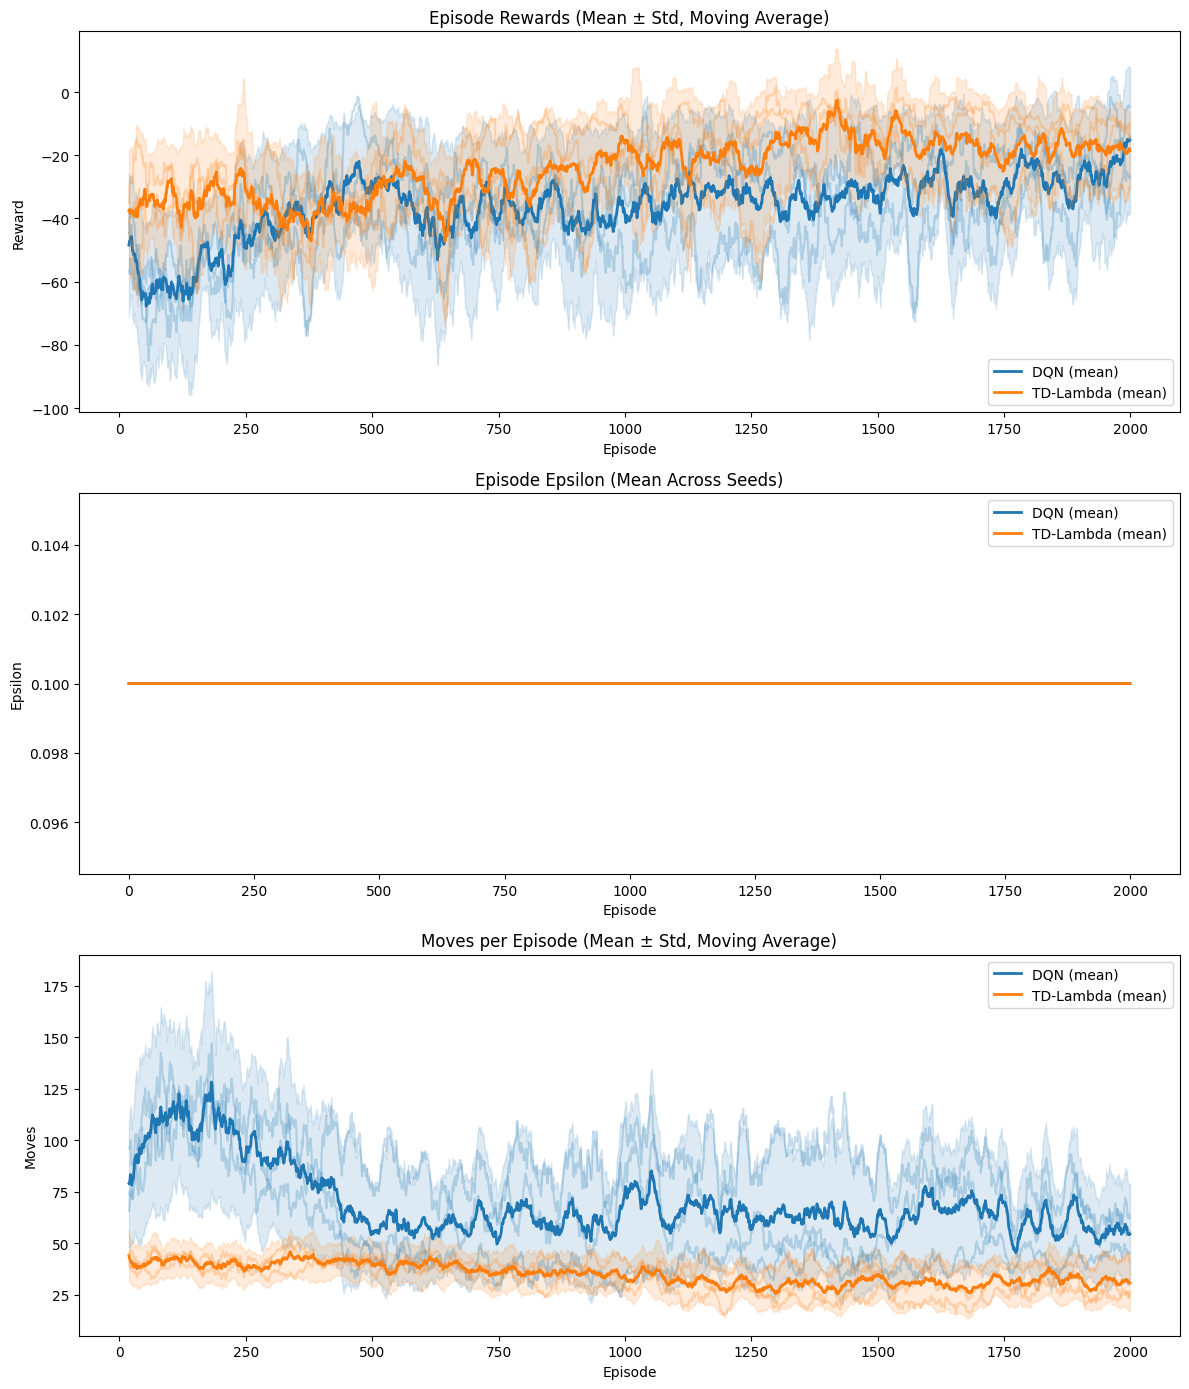

In [ ]:
plot_overlay_two_models(dqn_res_greedy_seed_results, "DQN", td_res_greedy_seed_results, "TD-Lambda")

Result with decay of .9

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


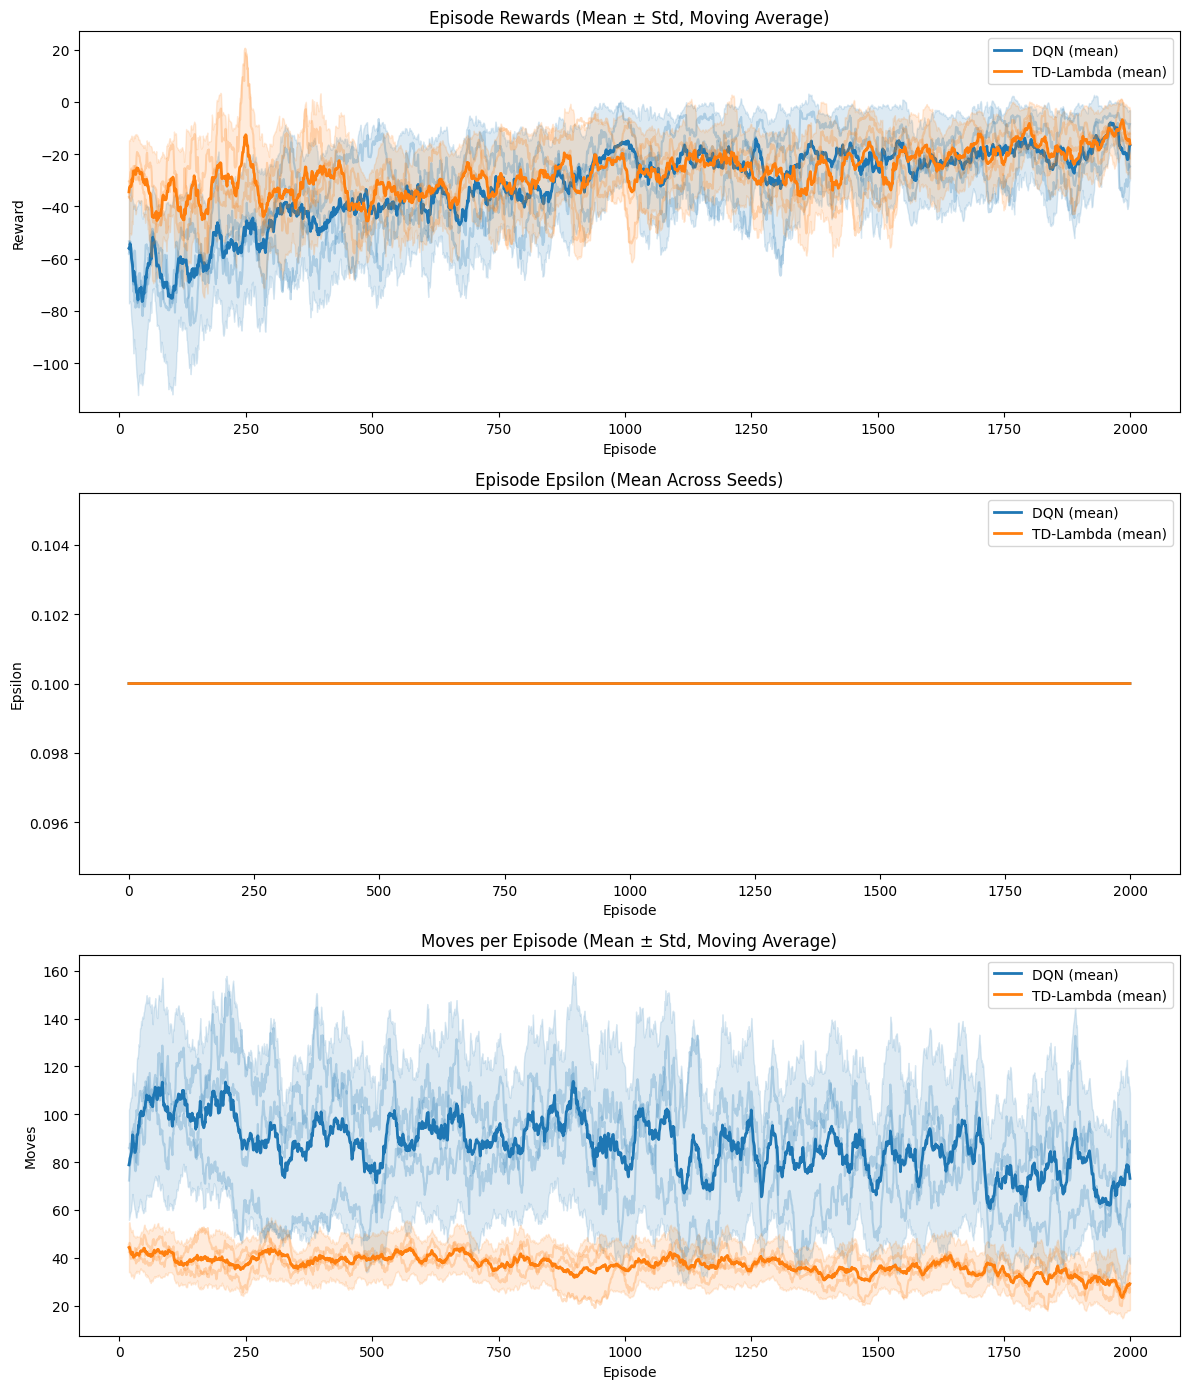

In [ ]:
plot_overlay_two_models(dqn_res_greedy_seed_results, "DQN", td_res_greedy_seed_results, "TD-Lambda")

# **DQN Training against Greedy Algorithm**

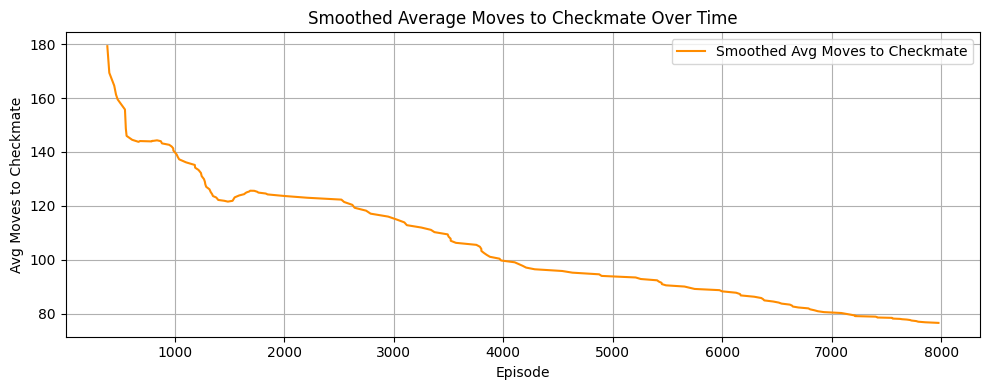

In [ ]:
# @title
import numpy as np

def moving_average(y_vals, window=10):
    y_vals = np.array(y_vals, dtype=np.float32)
    weights = np.ones(window) / window
    return np.convolve(y_vals, weights, mode='valid')

# Filter out None values and align their episode numbers
episodes = []
values = []
for i, v in enumerate(avg_moves_to_checkmate_over_time):
    if v is not None:
        episodes.append(i)
        values.append(v)

if len(values) >= 2:
    smoothed_values = moving_average(values, window=10)
    smoothed_episodes = episodes[len(episodes) - len(smoothed_values):]

    plt.figure(figsize=(10, 4))
    plt.plot(smoothed_episodes, smoothed_values, label='Smoothed Avg Moves to Checkmate', color='darkorange')
    plt.xlabel('Episode')
    plt.ylabel('Avg Moves to Checkmate')
    plt.title('Smoothed Average Moves to Checkmate Over Time')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


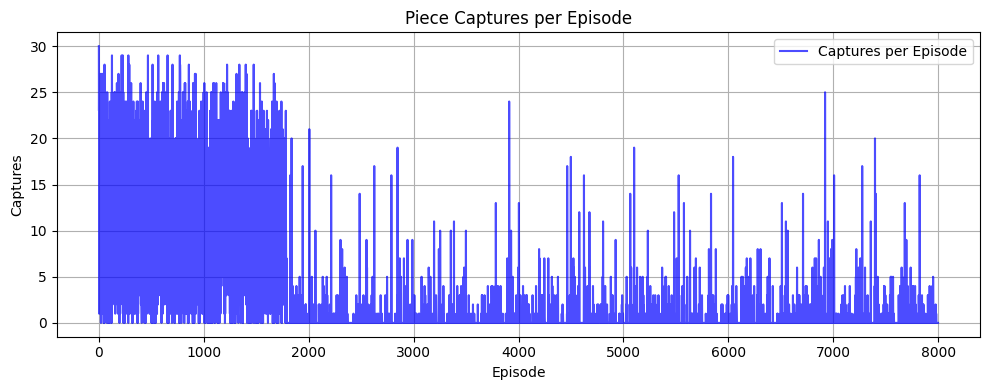

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(captures_per_episode, label='Captures per Episode', color='blue', alpha=0.7)
plt.xlabel('Episode')
plt.ylabel('Captures')
plt.title('Piece Captures per Episode')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def decode_move(index, color=chess.WHITE):
    if index < 4096:
        from_square = index // 64
        to_square = index % 64
        return chess.Move(from_square, to_square)
    else:
        promotion_index = index - 4096
        from_square = promotion_index // 4
        promo_piece = PROMOTION_PIECES[promotion_index % 4]
        rank_offset = 8 if color == chess.WHITE else -8
        to_square = from_square + rank_offset
        return chess.Move(from_square, to_square, promotion=chess.Piece.from_symbol(promo_piece).piece_type)


In [ ]:

import numpy as np
import random
from collections import defaultdict
import chess
import chess.engine
import torch
import torch.nn as nn
import torch.nn.functional as F

class MCTSNode:
    def __init__(self, board, parent=None, P=1.0):
        self.board = board.copy()
        self.parent = parent
        self.P = P
        self.N = 0
        self.W = 0
        self.Q = 0
        self.children = {}


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)


class PolicyValueNet(nn.Module):
    def __init__(self, channels=128, n_resblocks=3):
        super().__init__()
        self.conv_in = nn.Conv2d(13, channels, kernel_size=3, padding=1, bias=False)
        self.bn_in = nn.BatchNorm2d(channels)

        self.resblocks = nn.Sequential(*[ResidualBlock(channels) for _ in range(n_resblocks)])

        self.fc_shared = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * 8 * 8, 1024),
            nn.ReLU(),
        )

        self.policy_head = nn.Linear(1024, 4352)

        self.value_head = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Tanh()
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.relu(self.bn_in(self.conv_in(x)))
        x = self.resblocks(x)
        x = self.fc_shared(x)
        logits = self.policy_head(x)
        value = self.value_head(x).squeeze(-1)
        return logits, value


def network_policy_value_probs(network, board, device):
    turn = 1 if board.turn == chess.WHITE else -1
    state = board_to_tensor(board, turn).unsqueeze(0).to(device).float()

    network.eval()
    with torch.no_grad():
        logits, value = network(state)
        logits = logits[0]
        value = float(value[0].item())

    legal_mask = get_legal_tensor(board).to(torch.bool)
    illegal_move_mask = torch.full_like(logits, -1e9)
    allowed_logits = torch.where(legal_mask, logits, illegal_move_mask)

    probs = F.softmax(allowed_logits, dim=0).numpy()
    total = probs.sum()

    if not (total > 0 and np.isfinite(total)):
        legal_idx = np.nonzero(legal_mask.numpy())[0]
        probs = np.zeros(4352, dtype=np.float32)
        if len(legal_idx):
            probs[legal_idx] = 1.0 / len(legal_idx)
    else:
        probs /= probs.sum()

    return probs, value


def ucb_score(parent, child,c_puct=1.0):
    return child.Q + c_puct * child.P * np.sqrt(parent.N + 1)/(1 + child.N)


def select(node):
    if not node.children:
        return node
    best_idx = max(node.children, key=lambda idx: ucb_score(node, node.children[idx]))
    return select(node.children[best_idx])


def expand(node, network):
    tensor = board_to_tensor(node.board,1 if node.board.turn == chess.WHITE else -1).unsqueeze(0).to(device)

    logits, value = network(tensor)
    policy = logits.detach().cpu().numpy().flatten()

    for move in node.board.legal_moves:
        idx = encode_move(move)
        if idx not in node.children:
            child_board = node.board.copy()
            child_board.push(move)
            node.children[idx] = MCTSNode(child_board,parent=node,P=float(policy[idx]))

    return float(value)


def backup(node, value):
    while node:
      node.N += 1
      node.W +=value
      node.Q = node.W/node.N
      node = node.parent


def run_mcts(root, network,simulations=50):
    for i in range(simulations):
        leaf = select(root)
        if leaf.board.is_game_over():
            result = leaf.board.result()
            value = 1.0 if result == "1-0" else -1.0
        else:
            value = expand(leaf, network)

        backup(leaf, value)
    return root


def choose_action_from_root(root,temperature=1.0):
    if not root.children:
        legal = list(root.board.legal_moves)
        return random.choice(legal), None

    counts = np.array([child.N for child in root.children.values()])
    moves = list(root.children.keys())

    if temperature == 0:
        idx = moves[np.argmax(counts)]
        probs = None
    else:
        c = counts ** (1 / temperature)
        probs = c / c.sum()
        idx = np.random.choice(moves,p=probs)

    move = decode_move(idx)
    return move, probs



In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.capacity = capacity
        self.buffer = []
        self.pos = 0

    def add(self, state, pi, z):

        data = (state, pi, z)

        if len(self.buffer) < self.capacity:
            self.buffer.append(data)
        else:
            self.buffer[self.pos] =data
        self.pos = (self.pos +1) % self.capacity

    def sample(self, batch_size):
        idxs = torch.randint(0, len(self.buffer),(batch_size,))
        return [self.buffer[i] for i in idxs]

    def size(self):
        return len(self.buffer)




=== Iteration 1/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20


/tmp/ipython-input-308771141.py:133: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(value)


      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
 

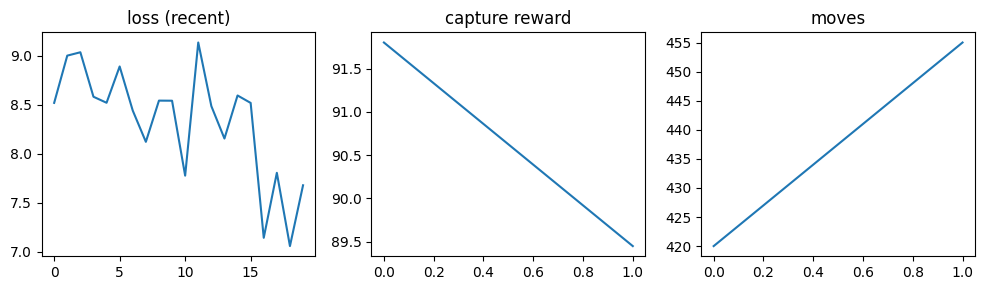


=== Iteration 2/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simul

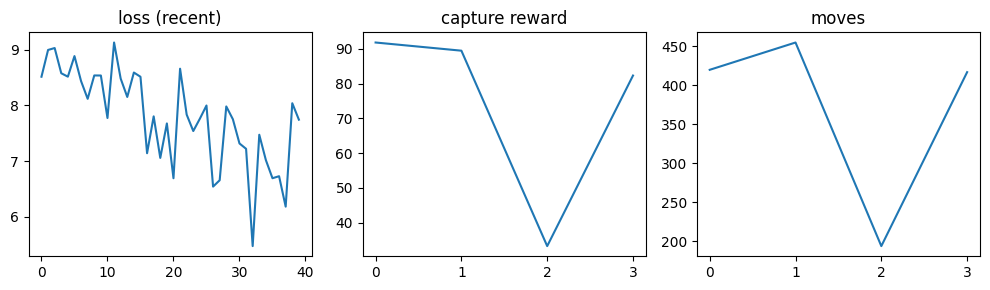


=== Iteration 3/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simul

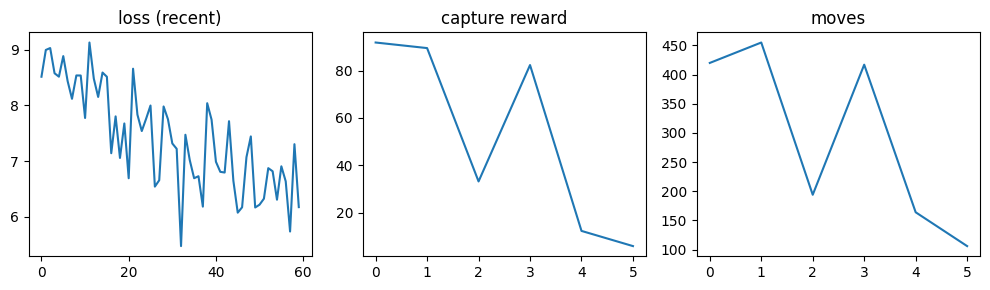


=== Iteration 4/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simul

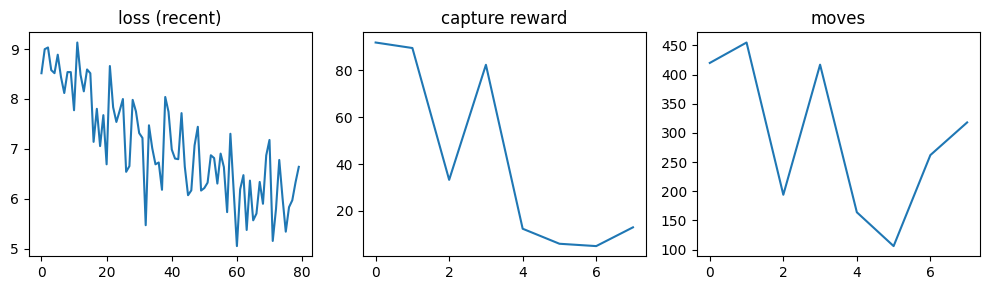


=== Iteration 5/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simul

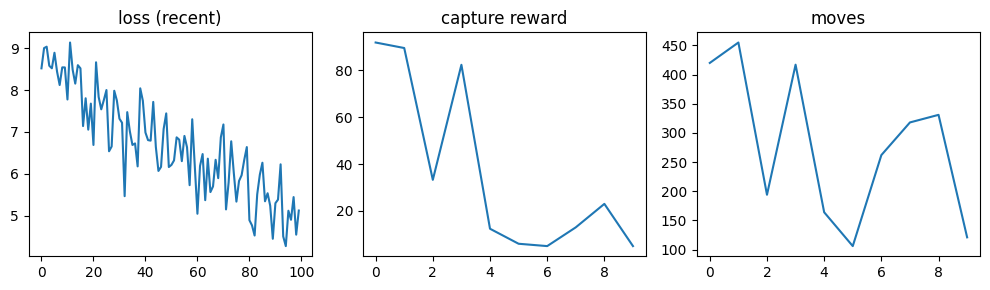


=== Iteration 6/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simul

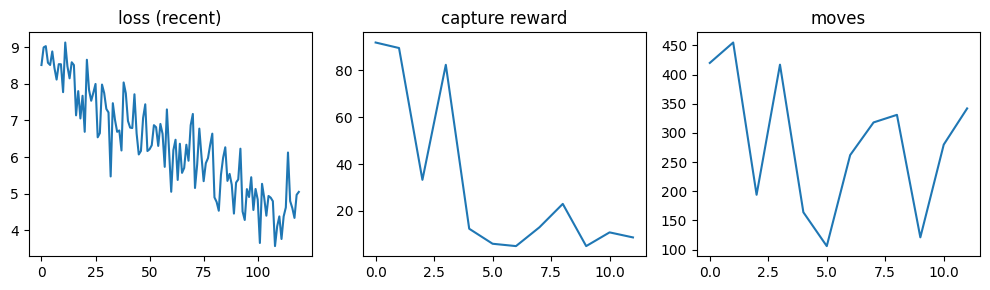


=== Iteration 7/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simul

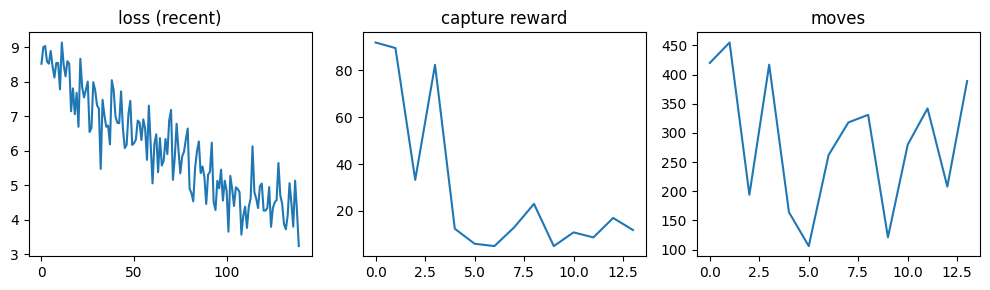


=== Iteration 8/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simul

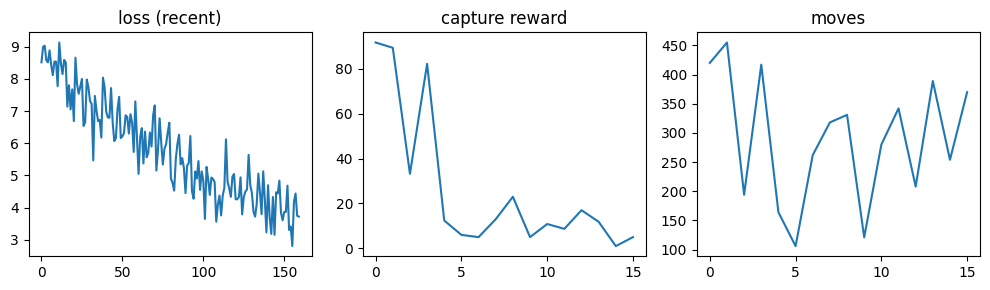


=== Iteration 9/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simul

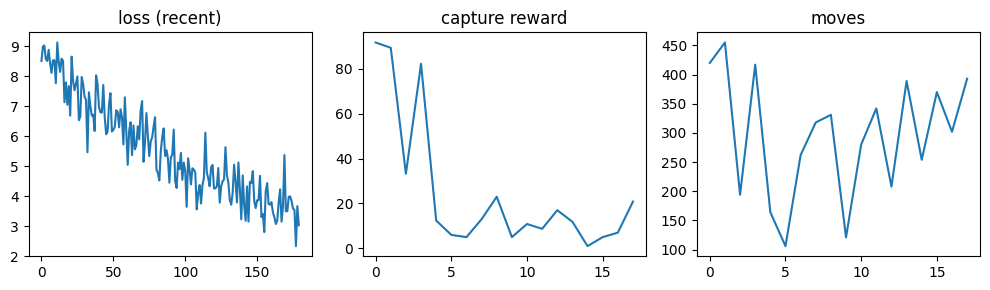


=== Iteration 10/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

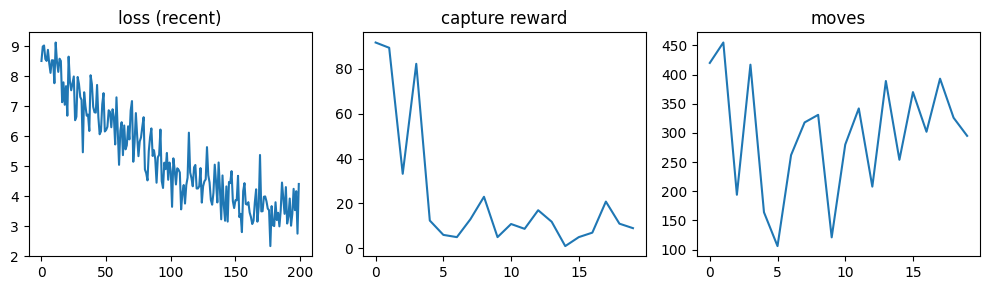


=== Iteration 11/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

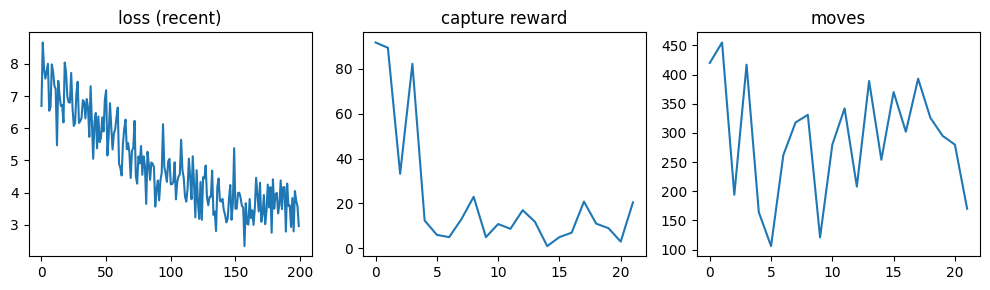


=== Iteration 12/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

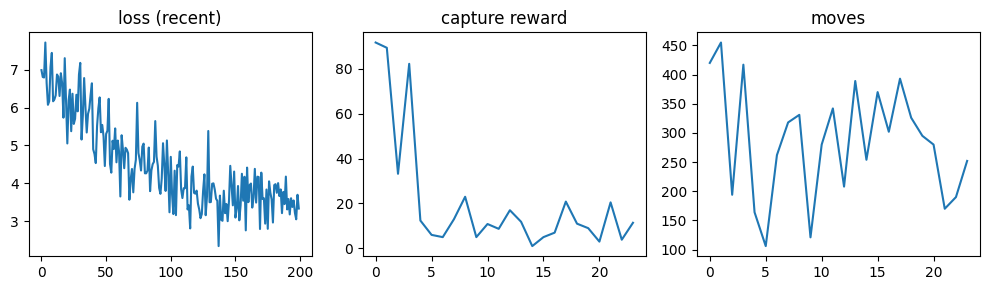


=== Iteration 13/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

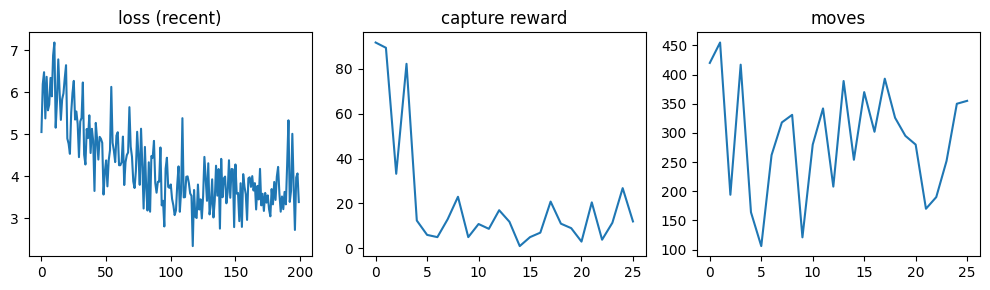


=== Iteration 14/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

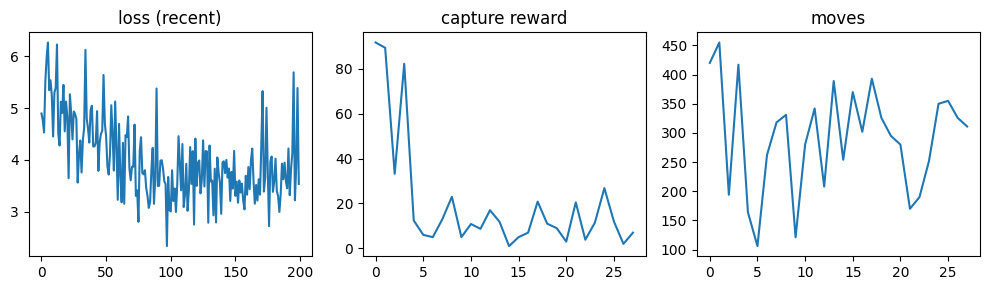


=== Iteration 15/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

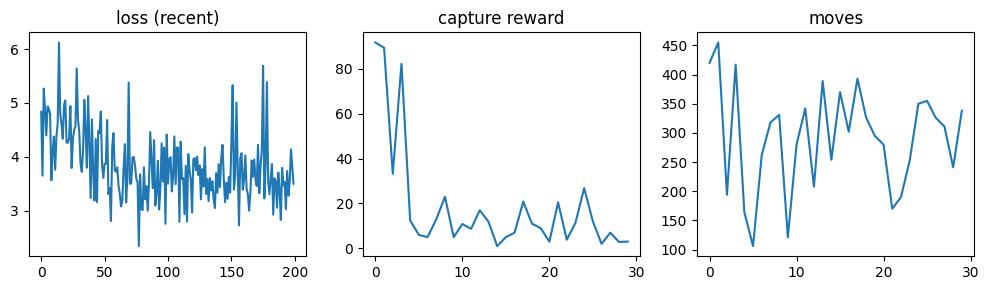


=== Iteration 16/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

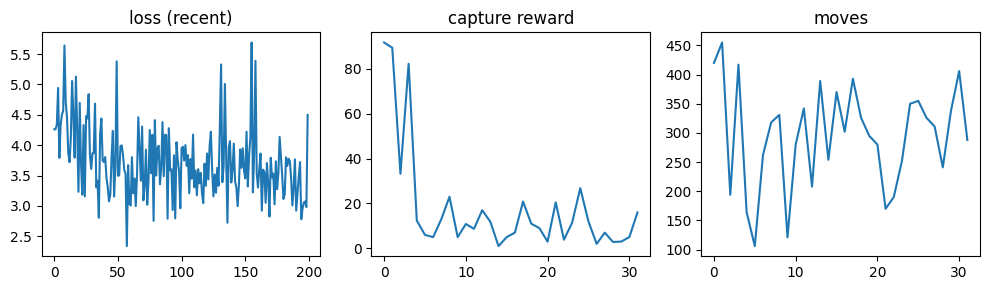


=== Iteration 17/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

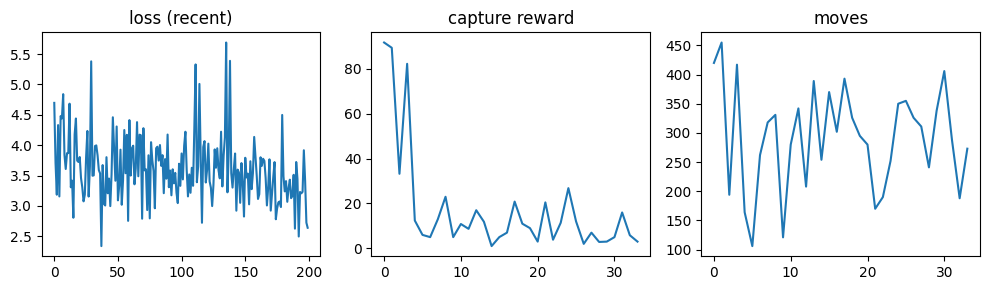


=== Iteration 18/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

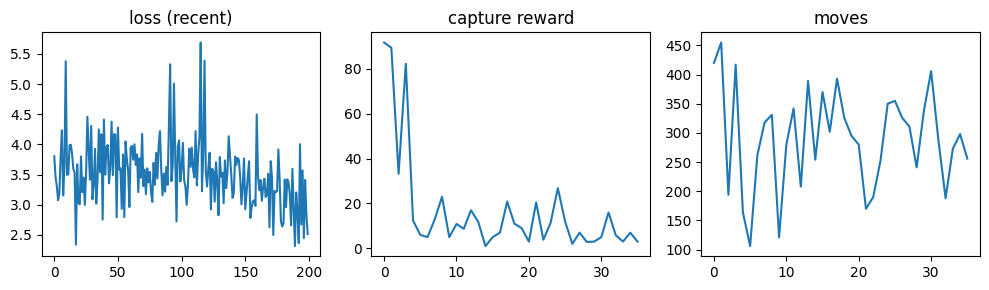


=== Iteration 19/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

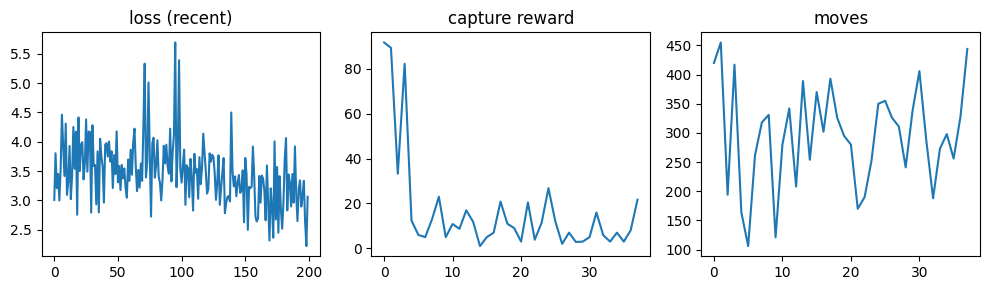


=== Iteration 20/20 ===
  MCTS Self-play game 1/2 (Simimulations=20)
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simulation 10/20
      MCTS simulation 15/20
      MCTS simulation 20/20
      MCTS simulation 5/20
      MCTS simu

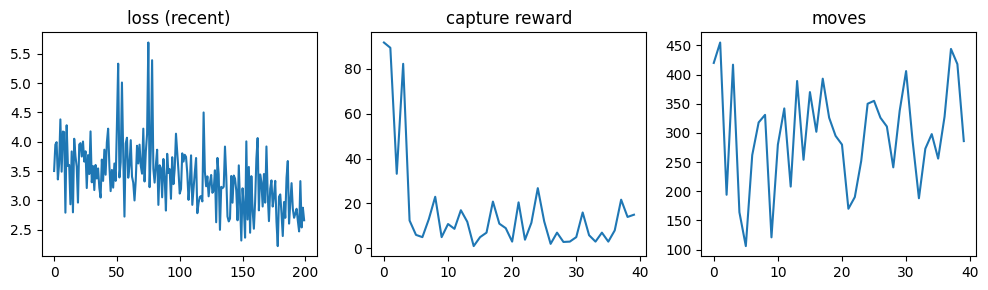

In [ ]:

import time
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

def get_policy_from_root(root):

    policy = np.zeros(4352, dtype=np.float32)
    if not root.children: #no children
        for move in root.board.legal_moves:
            policy[encode_move(move)] = 1.0
        s = policy.sum()
        if s > 0:
            policy /= s
        return policy

    for index, child in root.children.items():
        policy[index] = float(child.N)
    s = policy.sum()
    if s > 0:
        policy /= s
    else:
        for move in root.board.legal_moves:
            policy[encode_move(move)] = 1.0
        policy /= policy.sum()
    return policy

def add_noise(root, epsilon=0.25, alpha=0.03):
    keys = list(root.children.keys())
    if len(keys) == 0:
        return
    noise = np.random.dirichlet([alpha] * len(keys))
    for i, k in enumerate(keys):
        child = root.children[k]
        child.P = float((1 - epsilon) * child.P + epsilon * noise[i])

def run_mcts_with_progress(root, network, simulations=50, print_every=0):

    for simulation in range(1, simulations + 1):
        leaf = select(root)
        if leaf.board.is_game_over():
            result = leaf.board.result()
            value = 1.0 if result == "1-0" else -1.0 if result == "0-1" else 0.0
        else:

            value = expand(leaf, network)
        backup(leaf, value)
        if print_every and (simulation % print_every == 0):
            print(f"      MCTS simulation {simulation}/{simulations}", flush=True)
    return root


def train_on_batch(network, optimizer, batch, device):
    network.train()
    states, policies, final_results = zip(*batch)
    states = torch.stack(states).to(device)
    policies = torch.stack(policies).to(device)
    final_results = torch.tensor(final_results, dtype=torch.float32).to(device)

    optimizer.zero_grad()
    logits, values = network(states)
    log_of_probalilities = F.log_softmax(logits, dim=1)
    policy_loss = - (policies * log_of_probalilities).sum(dim=1).mean()
    values = values.squeeze(-1)
    value_loss = F.mse_loss(values, final_results)
    loss = policy_loss + value_loss
    loss.backward()
    optimizer.step()
    return float(loss.item()), float(policy_loss.item()), float(value_loss.item())


def self_play_game(network, device, simulations=50, dirichlet_eps=0.25, dirichlet_alpha=0.03,mcts_print_every=0):

    board = chess.Board()
    root = MCTSNode(board)
    examples = []
    capture_reward = 0.0
    moves = 0

    while not board.is_game_over():
        moves += 1

        root = run_mcts_with_progress(root, network, simulations=simulations, print_every=mcts_print_every)
        add_noise(root, epsilon=dirichlet_eps, alpha=dirichlet_alpha)
        policy = get_policy_from_root(root)
        policy_tensor = torch.from_numpy(policy).to(torch.float32)
        turn_flag = 1 if board.turn == chess.WHITE else -1
        state_tensor = board_to_tensor(board, turn_flag).to(torch.float32).cpu()

        examples.append((state_tensor, policy_tensor, turn_flag))
        move, _ = choose_action_from_root(root, temperature=1.0)
        if move is None:
            break


        capture_reward += get_capture_reward(board, move)
        board.push(move)
        root = MCTSNode(board)
    res = board.result()
    if res == "1-0":
        final_result = 1.0
    elif res == "0-1":
        final_result = -1.0
    else:
        final_result = 0.0

    return examples, final_result, capture_reward, moves


def mcts_training(network,device=None,iterations=10,games_per_iteration=4,simulations=50,replay_capacity=20000,batch_size=32,train_steps_per_iter=100,lr=2e-4,mcts_print_every=0,dirichlet_eps=0.25,dirichlet_alpha=0.03,print_every_iter=1):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network.to(device)
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)

    replay = ReplayBuffer(capacity=replay_capacity)

    all_losses = []
    all_policy_losses = []
    all_value_losses = []
    rewards_log = []
    moves_log = []

    for it in range(1, iterations + 1):
        iteration_examples = []
        iteration_rewards = []
        iteration_moves = []
        t0 = time.time()

        print(f"\n=== Iteration {it}/{iterations} ===", flush=True)


        for g in range(1, games_per_iteration + 1):
            print(f"  MCTS Self-play game {g}/{games_per_iteration} (Simimulations={simulations})", flush=True)
            examples, final_result, cap_reward, moves = self_play_game(
                network, device,
                simulations=simulations,
                dirichlet_eps=dirichlet_eps,
                dirichlet_alpha=dirichlet_alpha,
                mcts_print_every=mcts_print_every
            )

            for state_t, policie_t, player in examples:
                z = final_result * player
                replay.add(state_t, policie_t, float(z))

            iteration_examples.extend(examples)
            iteration_rewards.append(cap_reward)
            iteration_moves.append(moves)
            print(f"    finished game: moves = {moves}, capture reward = {cap_reward}, result = {final_result}", flush=True)


        print(f"  Training: {train_steps_per_iter} steps | batch size= {batch_size} | replay size = {replay.size()}", flush=True)
        iteration_loss_vals = []
        for step in range(1, train_steps_per_iter + 1):
            if replay.size() < batch_size:
                break
            batch = replay.sample(batch_size)
            loss, policy_loss, value_loss = train_on_batch(network,optimizer,batch, device)
            iteration_loss_vals.append(loss)
            all_losses.append(loss); all_policy_losses.append(policy_loss); all_value_losses.append(value_loss)

            if step % max(1, train_steps_per_iter // 10) == 0 or step == 1:
                print(f"    train step {step}/{train_steps_per_iter} | loss={loss:.4f} (p={policy_loss:.4f}, v={value_loss:.4f})", flush=True)

        rewards_log.extend(iteration_rewards)
        moves_log.extend(iteration_moves)
        t1 = time.time()


        avg_reward = np.mean(iteration_rewards) if iteration_rewards else float('nan')
        avg_moves = np.mean(iteration_moves) if iteration_moves else float('nan')
        avg_loss = np.mean(iteration_loss_vals) if iteration_loss_vals else float('nan')
        print(f"Iteration {it} complete in {t1-t0:.1f}s | avg_reward={avg_reward:.3f} | avg_moves={avg_moves:.1f} | avg_loss={avg_loss:.4f} | buffer={replay.size()}", flush=True)

        if it % print_every_iter == 0:
          plt.figure(figsize=(10,3))
          plt.subplot(1,3,1); plt.plot(all_losses[-200:]); plt.title('loss (recent)')
          plt.subplot(1,3,2); plt.plot(rewards_log[-50:]); plt.title('capture reward')
          plt.subplot(1,3,3); plt.plot(moves_log[-50:]); plt.title('moves')
          plt.tight_layout(); plt.show()


    return network, replay, all_losses, rewards_log, moves_log

network = PolicyValueNet().to(device)


network, buffer, losses, rewards, moves = mcts_training(
        network,
        device=device,
        iterations=20,
        games_per_iteration=2,
        simulations=20,
        replay_capacity=2000,
        batch_size=8,
        train_steps_per_iter=20,
        lr=1e-4,
        mcts_print_every=5,
        dirichlet_eps=0.25,
        dirichlet_alpha=0.03,
        print_every_iter=1
    )


In [ ]:
torch.save(network.state_dict(),"mcts_policy_value_network.pth")

### **Greedy Algorithm**

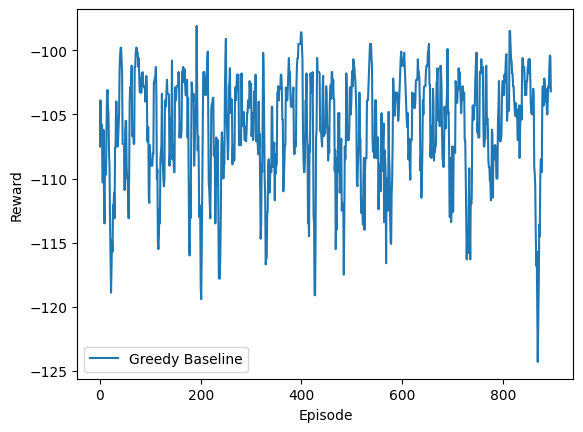

In [ ]:
def greedy_move(board):
    legal_moves = list(board.legal_moves)
    if not legal_moves:
        return None

    best_move = None
    best_reward = -float('inf')
    for move in legal_moves:
        reward = get_capture_reward(board, move)
        if reward > best_reward:
            best_reward = reward
            best_move = move

    if best_move is None:
        best_move = random.choice(legal_moves)

    return best_move

def run_greedy_baseline(num_games):
    engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
    episode_rewards = []

    for episode in range(num_games):
        board = chess.Board()
        total_reward = 0
        model_is_white = 1
        done = False

        while not done:
            # Greedy model move
            move = greedy_move(board)
            if move is None:
                break
            reward = get_capture_reward(board, move)
            total_reward += reward
            board.push(move)

            if not board.is_game_over():
                result = engine.play(board, chess.engine.Limit(time=0.1))
                stockfish_move = result.move
                reward = -get_capture_reward(board, stockfish_move)
                total_reward += reward
                board.push(stockfish_move)

            if board.is_game_over():
                result_str = board.result()
                if (result_str == "1-0" and model_is_white == 1) or (result_str == "0-1" and model_is_white == 0):
                    total_reward += 100
                elif result_str == "1/2-1/2" or board.is_stalemate():
                    total_reward += 0
                else:
                    total_reward -= 100
                done = True

        episode_rewards.append(total_reward)
        model_is_white = 0 if model_is_white == 1 else 1

    engine.quit()
    return episode_rewards

greedy_rewards = run_greedy_baseline(num_games=900)
# plt.plot(moving_average(td_lambda_rewards, window=5), label="TD(λ)")
plt.plot(moving_average(greedy_rewards, window=5), label="Greedy Baseline")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()



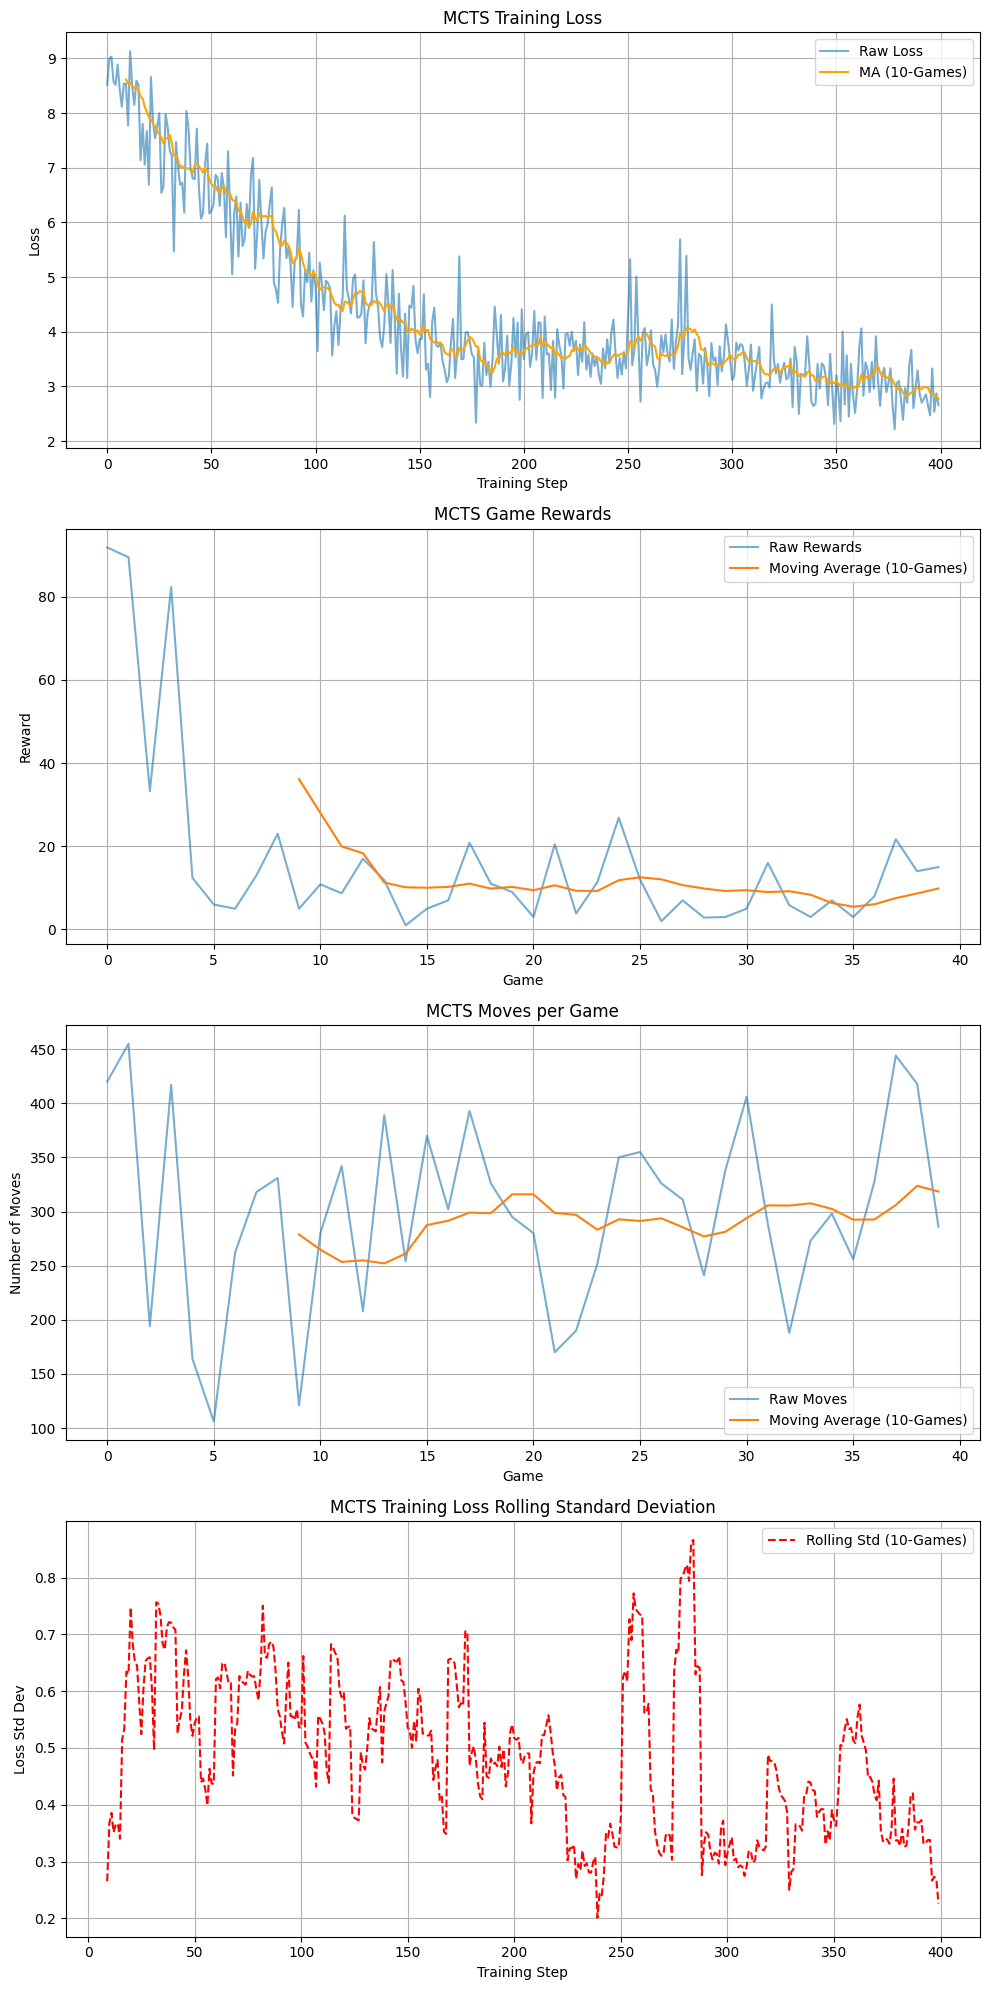

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(values, window):
    if len(values) < window:
        return np.array(values)
    return np.convolve(values, np.ones(window)/window, mode='valid')

def rolling_std(values, window):
    if len(values) < window:
        return np.array([])
    stds = [np.std(values[i:i+window]) for i in range(len(values) - window + 1)]
    return np.array(stds)


fig, axes = plt.subplots(4, 1, figsize=(10, 20))

axes[0].plot(losses, label='Raw Loss', alpha=0.6)
ma_losses = moving_average(losses, window=10)
if len(ma_losses) > 0:
    axes[0].plot(range(9, len(losses)), ma_losses, label='MA (10-Games)', color='orange')
axes[0].set_title("MCTS Training Loss")
axes[0].set_xlabel("Training Step")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(rewards, label='Raw Rewards', alpha=0.6)
ma_rewards = moving_average(rewards, window=10)
if len(ma_rewards) > 0:
    axes[1].plot(range(9, len(rewards)), ma_rewards, label='Moving Average (10-Games)')
axes[1].set_title("MCTS Game Rewards")
axes[1].set_xlabel("Game")
axes[1].set_ylabel("Reward")
axes[1].legend()
axes[1].grid(True)


axes[2].plot(moves, label='Raw Moves', alpha=0.6)
ma_moves = moving_average(moves, window=10)
if len(ma_moves) > 0:
    axes[2].plot(range(9, len(moves)), ma_moves, label='Moving Average (10-Games)')
axes[2].set_title("MCTS Moves per Game")
axes[2].set_xlabel("Game")
axes[2].set_ylabel("Number of Moves")
axes[2].legend()
axes[2].grid(True)


rs_losses = rolling_std(losses, window=10)
if len(rs_losses) > 0:
    axes[3].plot(range(9, len(losses)), rs_losses, label='Rolling Std (10-Games)', color='red', linestyle='--')
axes[3].set_title("MCTS Training Loss Rolling Standard Deviation")
axes[3].set_xlabel("Training Step")
axes[3].set_ylabel("Loss Std Dev")
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import os
import torch

# Ensure drive_save_path is defined (it should be from previous cells)
drive_save_path = '/content/drive/My Drive/Colab_Chess_Models'
os.makedirs(drive_save_path, exist_ok=True)

# Assuming 'network' is your trained PolicyValueNet instance
model_filename_mcts = 'mcts_policy_value_network_final.pth'
full_model_path_mcts = os.path.join(drive_save_path, model_filename_mcts)

torch.save(network.state_dict(), full_model_path_mcts)

print(f"MCTS PolicyValueNet saved to: {full_model_path_mcts}")

MCTS PolicyValueNet saved to: /content/drive/My Drive/Colab_Chess_Models/mcts_policy_value_network_final.pth


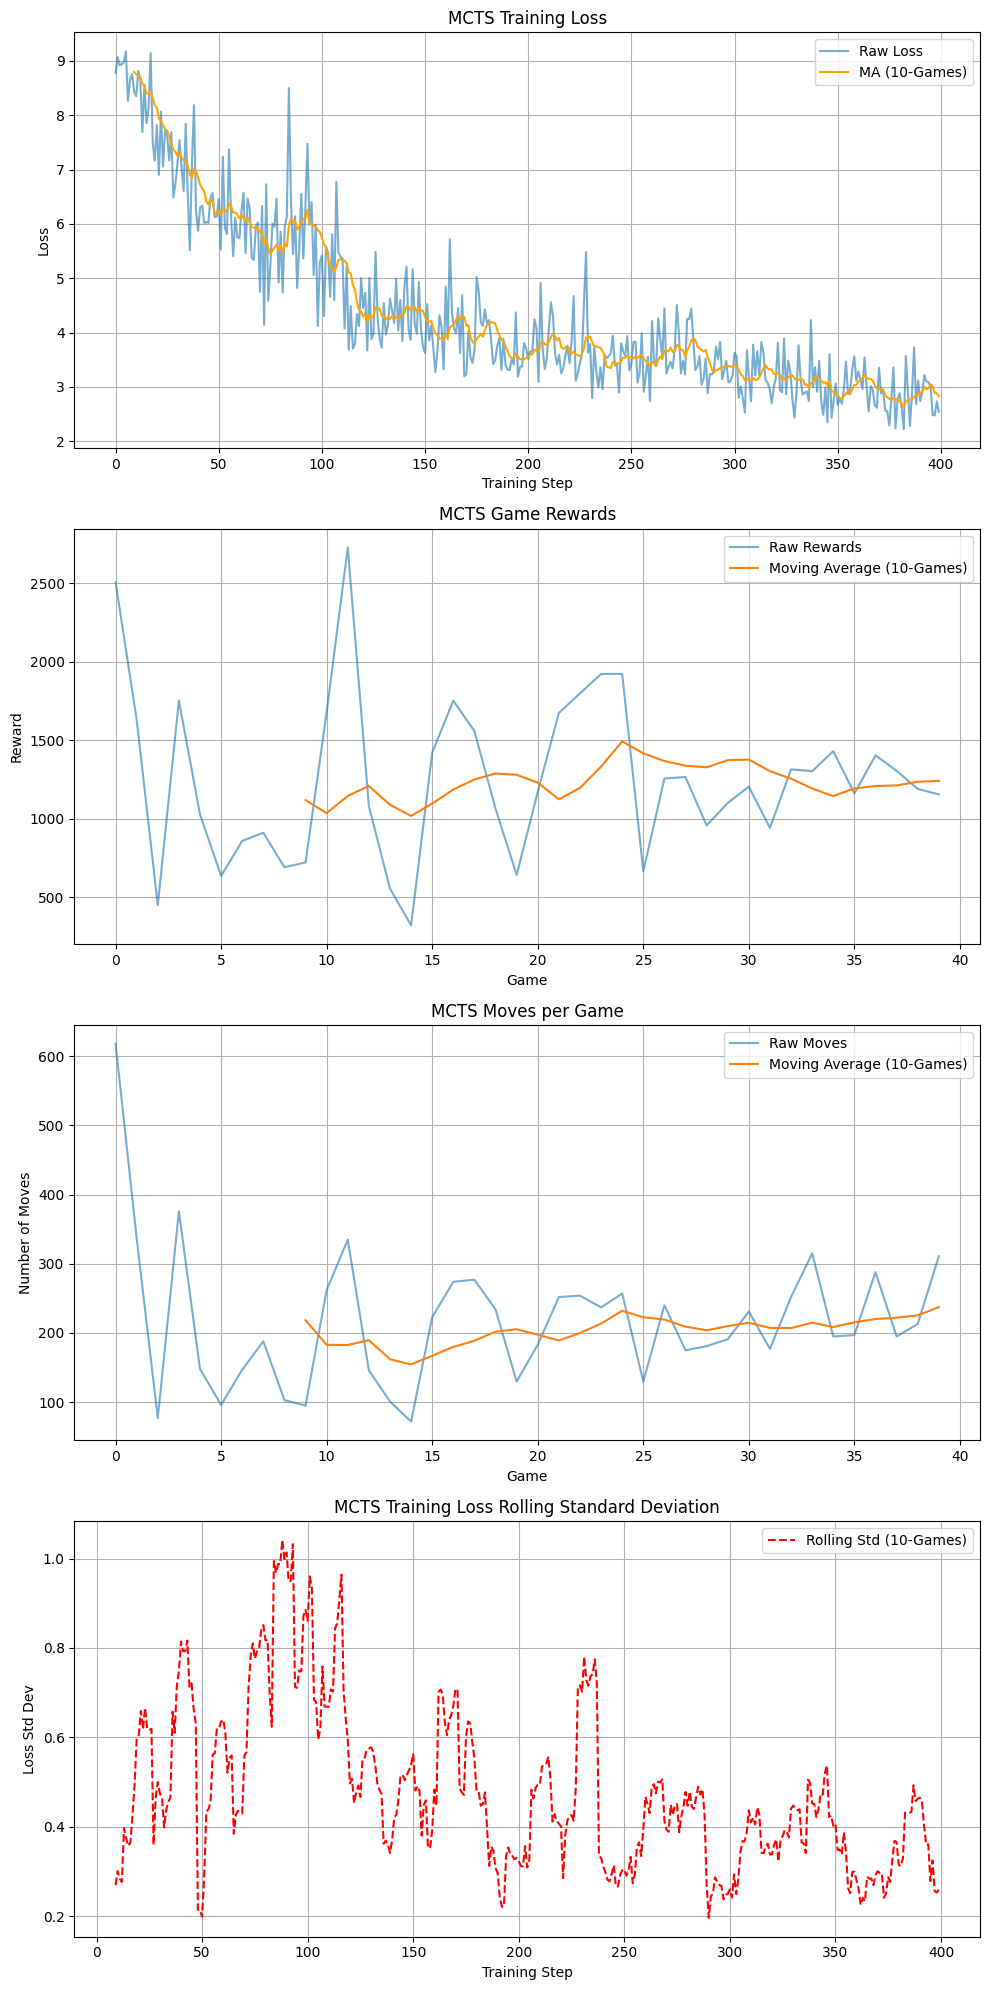

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(values, window):
    if len(values) < window:
        return np.array(values)
    return np.convolve(values, np.ones(window)/window, mode='valid')

def rolling_std(values, window):
    if len(values) < window:
        return np.array([])
    stds = [np.std(values[i:i+window]) for i in range(len(values) - window + 1)]
    return np.array(stds)


fig, axes = plt.subplots(4, 1, figsize=(10, 20))


axes[0].plot(losses, label='Raw Loss', alpha=0.6)
ma_losses = moving_average(losses, window=10)
if len(ma_losses) > 0:
    axes[0].plot(range(9, len(losses)), ma_losses, label='MA (10-Games)', color='orange')
axes[0].set_title("MCTS Training Loss")
axes[0].set_xlabel("Training Step")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(rewards, label='Raw Rewards', alpha=0.6)
ma_rewards = moving_average(rewards, window=10)
if len(ma_rewards) > 0:
    axes[1].plot(range(9, len(rewards)), ma_rewards, label='Moving Average (10-Games)')
axes[1].set_title("MCTS Game Rewards")
axes[1].set_xlabel("Game")
axes[1].set_ylabel("Reward")
axes[1].legend()
axes[1].grid(True)


axes[2].plot(moves, label='Raw Moves', alpha=0.6)
ma_moves = moving_average(moves, window=10)
if len(ma_moves) > 0:
    axes[2].plot(range(9, len(moves)), ma_moves, label='Moving Average (10-Games)')
axes[2].set_title("MCTS Moves per Game")
axes[2].set_xlabel("Game")
axes[2].set_ylabel("Number of Moves")
axes[2].legend()
axes[2].grid(True)


rs_losses = rolling_std(losses, window=10)
if len(rs_losses) > 0:
    axes[3].plot(range(9, len(losses)), rs_losses, label='Rolling Std (10-Games)', color='red', linestyle='--')
axes[3].set_title("MCTS Training Loss Rolling Standard Deviation")
axes[3].set_xlabel("Training Step")
axes[3].set_ylabel("Loss Std Dev")
axes[3].legend()
axes[3].grid(True)


plt.tight_layout()
plt.show()

In [ ]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive_save_path = '/content/drive/My Drive/Colab_Chess_Models'

model_filename_dqn = 'dqn_model_final.pth'
full_model_path_dqn = os.path.join(drive_save_path, model_filename_dqn)

dqn_model = DQN().to(device)
dqn_model.load_state_dict(torch.load(full_model_path_dqn, map_location=device))
dqn_model.eval()

print(f"DQN model loaded from: {full_model_path_dqn}")


model_filename_td = 'td_lambda_model_final.pth'
full_model_path_td = os.path.join(drive_save_path, model_filename_td)

td_lambda_value_net = TDLambdaValueNetwork().to(device)
td_lambda_value_net.load_state_dict(torch.load(full_model_path_td, map_location=device))
td_lambda_value_net.eval()

td_lambda_agent = TDLambdaAgent(td_lambda_value_net, lr=0, gamma=0, lambda_val=0)

print(f"TD-Lambda model loaded from: {full_model_path_td}")

DQN model loaded from: /content/drive/My Drive/Colab_Chess_Models/dqn_model_final.pth
TD-Lambda model loaded from: /content/drive/My Drive/Colab_Chess_Models/td_lambda_model_final.pth


In [ ]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive_save_path = '/content/drive/My Drive/Colab_Chess_Models'


model_filename_mcts = 'mcts_policy_value_network_final.pth'
full_model_path_mcts = os.path.join(drive_save_path, model_filename_mcts)
network = PolicyValueNet().to(device)
network.load_state_dict(torch.load(full_model_path_mcts, map_location=device))
network.eval()

print(f"MCTS PolicyValueNet loaded from: {full_model_path_mcts}")

MCTS PolicyValueNet loaded from: /content/drive/My Drive/Colab_Chess_Models/mcts_policy_value_network_final.pth


In [ ]:
import os
import torch

model_filename_td = 'td_lambda_model_final.pth'
full_model_path_td = os.path.join(drive_save_path, model_filename_td)

torch.save(td_lambda_value_net.state_dict(), full_model_path_td)

print(f"TD-Lambda model saved to: {full_model_path_td}")

TD-Lambda model saved to: /content/drive/My Drive/Colab_Chess_Models/td_lambda_model_final.pth


In [ ]:
import random
import torch
import chess

def epsilon_action(board, epsilon):
    if random.random() < epsilon:
        if random.random() < 0.5:
            return random.choice(list(board.legal_moves))
        else:
            return greedy_move(board)
    return None

def get_capture_reward(board, move):
    reward = 0

    if board.is_capture(move):
        captured = board.piece_at(move.to_square)
        if captured:
            reward += {
                chess.PAWN: 1,
                chess.KNIGHT: 3,
                chess.BISHOP: 3,
                chess.ROOK: 5,
                chess.QUEEN: 9,
            }.get(captured.piece_type, 0)

    temp_board = board.copy()
    temp_board.push(move)
    if temp_board.is_check():
        reward += 0.5

    return reward


def greedy_move(board):
    best_score = -float('inf')
    best_move = None

    for move in board.legal_moves:
        score = get_capture_reward(board, move)
        if score > best_score:
            best_score = score
            best_move = move

    return best_move if best_move else random.choice(list(board.legal_moves))

class RandomAgent:
    def __init__(self, name="random"):
        self.name = name

    def select_move(self,board,device=None,turn=None):
        return random.choice(list(board.legal_moves))


class GreedyAgent:
    def __init__(self, name="greedy"):
        self.name = name

    def select_move(self,board,device=None,turn=None):
        return greedy_move(board)



class DQNAgent:
    def __init__(self, q_network,epsilon=0.1, name="dqn"):
        self.q_network = q_network.eval()
        self.epsilon = epsilon
        self.name = name

    def select_move(self,board,device,turn=None):

        explore = epsilon_action(board,self.epsilon)
        if explore is not None:
            return explore

        state = board_to_tensor(board,turn).to(device)
        q_values = self.q_network(state.unsqueeze(0)).squeeze(0)

        legal_mask = get_legal_tensor(board).to(device)
        q_values[legal_mask == 0] = -float("inf")

        idx = torch.argmax(q_values).item()
        move = decode_move(idx)

        if move not in board.legal_moves:
            return random.choice(list(board.legal_moves))

        return move

class TDLambdaEvalAgent:
    def __init__(self, td_lambda_agent_instance, epsilon=0.1, name="td_lambda"):
        self.agent_instance = td_lambda_agent_instance
        self.epsilon = epsilon
        self.name = name

    def select_move(self, board, device, turn):
        explore = epsilon_action(board, self.epsilon)
        if explore is not None:
            return explore

        best_move = None
        best_value = -float("inf")

        for move in board.legal_moves:
            board.push(move)

            value = self.agent_instance.predict(board_to_tensor(board, -turn))
            board.pop()

            if value > best_value:
                best_value = value
                best_move = move

        return best_move if best_move else random.choice(list(board.legal_moves))


class MCTSAgent:
    def __init__(self, policy_value_net, name="mcts"):
        self.pvnet = policy_value_net
        self.name = name

    def select_move(self, board, device=None, turn=None):
        root = MCTSNode(board)
        root = run_mcts(root, self.pvnet, simulations=50)
        move, _ = choose_action_from_root(root, temperature=0.0)
        return move


def run_game_between_agents(agent_white, agent_black, num_games=10, device=None, verbose=False):
    results = {'white_wins': 0, 'black_wins': 0, 'draws': 0}

    for game in range(num_games):
        board = chess.Board()

        while not board.is_game_over():
            agent = agent_white if board.turn == chess.WHITE else agent_black
            turn = 1 if board.turn == chess.WHITE else -1
            print('\n')
            print(board)
            print('\n')

            try:
                move = agent.select_move(board, turn=turn)

            except TypeError:
                move = agent.select_move(board, device=device, turn=turn)

            if move not in board.legal_moves:

                if board.turn == chess.WHITE:
                    results['black_wins'] += 1
                else:
                    results['white_wins'] += 1
                break

            board.push(move)

        if board.is_game_over():
            res = board.result()
            if res == "1-0":
                results['white_wins'] += 1
            elif res == "0-1":
                results['black_wins'] += 1
            else:
                results['draws'] += 1

    total = num_games

    return {
        "white_agent": agent_white.name,
        "black_agent": agent_black.name,
        "white_wins": results['white_wins'],
        "black_wins": results['black_wins'],
        "draws": results['draws'],
        "total_games": total,
        "white_win_rate": results['white_wins'] / total,
        "black_win_rate": results['black_wins'] / total,
    }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dqn_agent = DQNAgent(
    q_network=dqn_model,
    epsilon=0.2,
    name="DQN_Agent"
)

td_lambda_agent_eval = TDLambdaEvalAgent(
    td_lambda_agent_instance=td_lambda_agent,
    epsilon=0.2,
    name="TDLambda_Agent"
)

mcts_agent = MCTSAgent(
    policy_value_net=network,
    name="MCTS_Agent"
)

greedy_agent = GreedyAgent(name="Greedy_Agent")
random_agent = RandomAgent(name="Random_Agent")

In [ ]:
results = run_game_between_agents(
    agent_white=dqn_agent,
    agent_black=td_lambda_agent_eval,
    num_games=1000,
    device=device,
    verbose=False
)

print(results)

Streaming output truncated to the last 5000 lines.
. B . . . . . .
P . . . . . . .
. P . P . . . .
. . . P K P P P
. . R . Q R . .




r n b . . b r .
. p . k p p . p
p . p . . p . .
. B . . . . . .
P . . . . . . .
. P . P . . . .
. . . P K P P P
. . R . Q R . .




r n b . . b r .
. p . k p p . p
p . p . . p . .
. B . . . . . .
P . . . . . . .
. P . P . . . .
. . . P K P P P
. . . R Q R . .




. n b . . b r .
r p . k p p . p
p . p . . p . .
. B . . . . . .
P . . . . . . .
. P . P . . . .
. . . P K P P P
. . . R Q R . .




. n b . . b r .
r p . k p p . p
p . p . . p . .
. B . . . . . .
P . . . . . . .
. P . P . . . .
. . . P K P P P
. . . R Q . R .




. n b . . b r .
r p . . p p . p
p . p k . p . .
. B . . . . . .
P . . . . . . .
. P . P . . . .
. . . P K P P P
. . . R Q . R .




. n b . . b r .
r p . . p p . p
p . p k . p . .
. B . . . . . .
P . . P . . . .
. P . . . . . .
. . . P K P P P
. . . R Q . R .




. n b . . b . .
r p . . p p . p
p . p k . p . .
. B . . . . . .
P . . P .

In [ ]:
results = run_game_between_agents(
    agent_white=dqn_agent,
    agent_black=mcts_agent,
    num_games=10,
    device=device,
    verbose=True
)

print(results)


Streaming output truncated to the last 5000 lines.
. . . . . . p .
. P . . . . N .
. . . . . . . .
P B P P P P P P
. . R Q K B R .




r n b . k b . r
. . q . p p . p
p p . p . . . n
. . . . N . p .
. P . . . . . .
. . . . . . . .
P B P P P P P P
. . R Q K B R .




r n b . k b r .
. . q . p p . p
p p . p . . . n
. . . . N . p .
. P . . . . . .
. . . . . . . .
P B P P P P P P
. . R Q K B R .




r n b . k b r .
. . q . p p . p
p p . p . . . n
. . . . . . p .
. P . . . . N .
. . . . . . . .
P B P P P P P P
. . R Q K B R .




r n b . k b . r
. . q . p p . p
p p . p . . . n
. . . . . . p .
. P . . . . N .
. . . . . . . .
P B P P P P P P
. . R Q K B R .




r n b . k b . B
. . q . p p . p
p p . p . . . n
. . . . . . p .
. P . . . . N .
. . . . . . . .
P . P P P P P P
. . R Q K B R .




r n b . k b . B
. . . . p p . p
p p . p . . . n
. . q . . . p .
. P . . . . N .
. . . . . . . .
P . P P P P P P
. . R Q K B R .




r n b . k b . B
. . . . p p . p
p p . p . . . n
. . q . N . p .
. P . . .

In [ ]:
results = run_game_between_agents(
    agent_white=td_lambda_agent_eval,
    agent_black=mcts_agent,
    num_games=10,
    device=device,
    verbose=True
)

print(results)

Streaming output truncated to the last 5000 lines.
. . p . . . p .
. . . . . . P .
N . P . P . . .
P P . P K . P P
. R B . . B R .




r n b . . . . .
. . . k p . Q .
p p . . N . . .
. . p . . . p .
. . . . . . P .
N . P . P . . .
P P . P . K P P
. R B . . B R .




r n . . . . . .
. b . k p . Q .
p p . . N . . .
. . p . . . p .
. . . . . . P .
N . P . P . . .
P P . P . K P P
. R B . . B R .




r n . . . . . .
. b . k Q . . .
p p . . N . . .
. . p . . . p .
. . . . . . P .
N . P . P . . .
P P . P . K P P
. R B . . B R .




r n . . . . . .
. b . . Q . . .
p p k . N . . .
. . p . . . p .
. . . . . . P .
N . P . P . . .
P P . P . K P P
. R B . . B R .




r n . . . . . .
. b . . . . Q .
p p k . N . . .
. . p . . . p .
. . . . . . P .
N . P . P . . .
P P . P . K P P
. R B . . B R .




r n b . . . . .
. . . . . . Q .
p p k . N . . .
. . p . . . p .
. . . . . . P .
N . P . P . . .
P P . P . K P P
. R B . . B R .




r n b . . . . .
. . . . . . Q .
p p k . . . . .
. . p . . . N .
. . . . .